# Lab 3 - Hopfield networks

## Imports


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
from IPython.display import display
import itertools

from hopfield_network import HopfieldNetwork

## Define the model


## Test the model


In [2]:
x1 = [-1, -1, 1, -1, 1, -1, -1, 1]
x2 = [-1, -1, -1, -1, -1, 1, -1, -1]
x3 = [-1, 1, 1, -1, -1, 1, -1, 1]
X = torch.tensor([x1, x2, x3], dtype=torch.float32)

hopfield = HopfieldNetwork(X.shape[1])
hopfield.train(X)
# Check if all patterns are stable
for x in X:
    assert torch.all(hopfield.update_rule(x) == x)
print("All patterns are stable")

All patterns are stable


## 3.1 - Convergence and attractors


In [3]:
x1d = [1, -1, 1, -1, 1, -1, -1, 1]
x2d = [1, 1, -1, -1, -1, 1, -1, -1]
x3d = [1, 1, 1, -1, 1, 1, -1, 1]

Xd = torch.tensor([x1d, x2d, x3d], dtype=torch.float32)

for x in Xd:
    y = hopfield.predict_sync(x)
    print(y)

tensor([-1., -1.,  1., -1.,  1., -1., -1.,  1.])
tensor([-1., -1., -1., -1., -1.,  1., -1., -1.])
tensor([-1.,  1.,  1., -1., -1.,  1., -1.,  1.])


> They are not converging to the same attractor.


In [4]:
# Search number of attractors
attractors = hopfield.attractors()
print(f"Number of attractors: {attractors.shape[0]}")

Number of attractors: 16


In [5]:
x1d_modified = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.float32)

y = hopfield.predict_sync(x1d_modified)
print(y)

tensor([ 1.,  1.,  1.,  1.,  1., -1.,  1.,  1.])


> When we make the starting pattern even more dissimilar to the stored ones we get attracted to a false value (predictable)


## 3.2 - Sequential Update


data.shape: torch.Size([11, 1024])


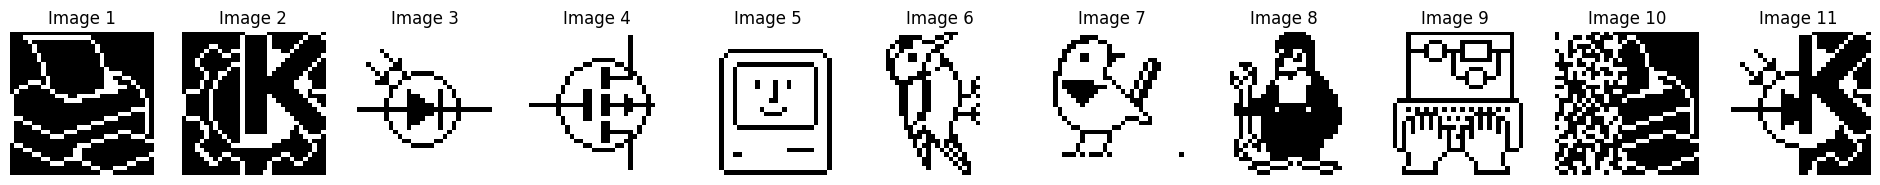

In [6]:
dim = 1024
file = "pict.dat"
data = pd.read_csv(file, sep=",", header=None)
data = data.to_numpy()
data = data.reshape(-1, dim)
data = torch.tensor(data, dtype=torch.float32)
print("data.shape:", data.shape)


def plot_images(images, shape, title, filename=None):
    fig, axes = plt.subplots(1, len(images), figsize=(24, 24))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].reshape(shape).T, cmap="gray")
        ax.set_title(title[i])
        ax.axis("off")
    if filename:
        plt.savefig(filename)
    plt.show()


plot_images(data, (32, 32), [
            f"Image {i+1}" for i in range(data.shape[0])], "images/original_images.png")

All patterns are stable


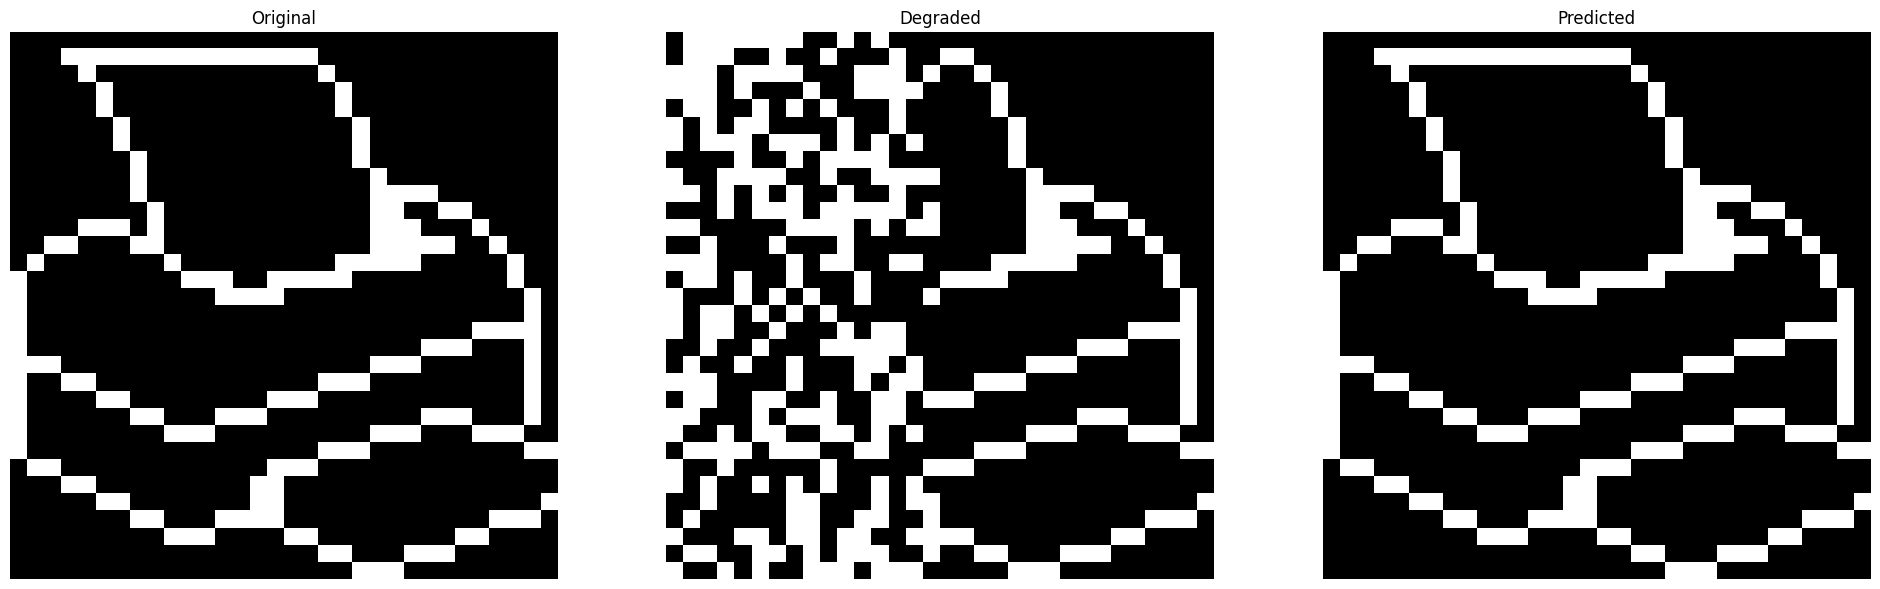

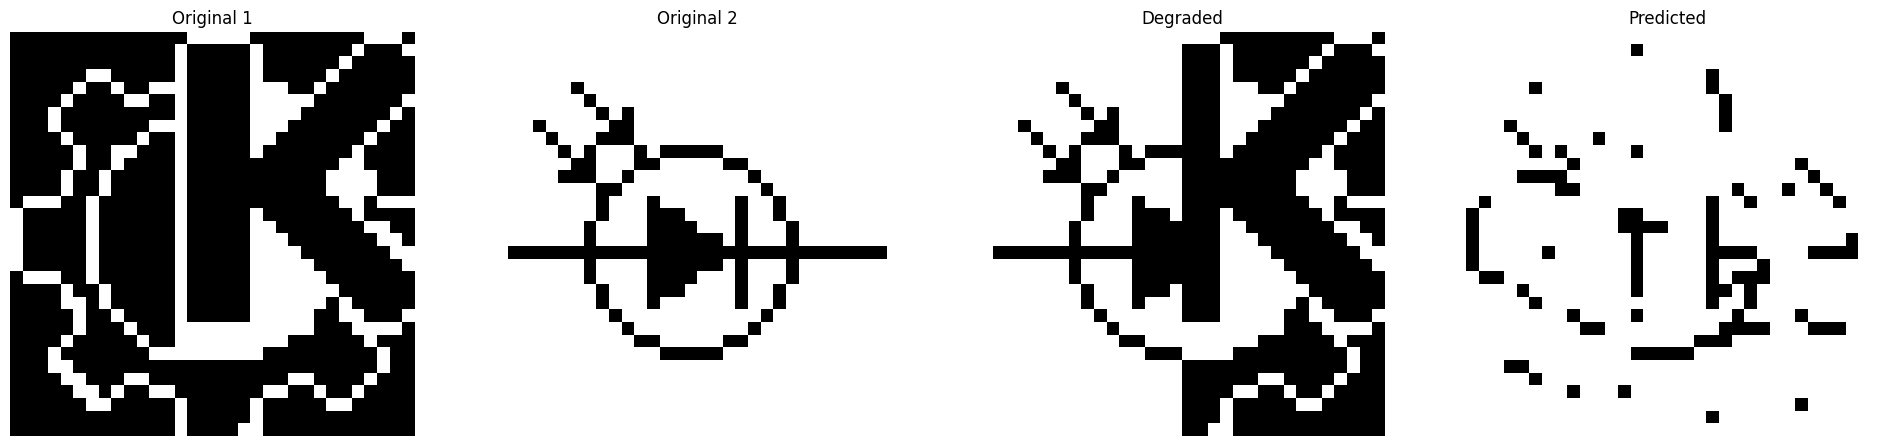

In [7]:
hopfield_seq = HopfieldNetwork(dim)
# Train the network with the first three images
hopfield_seq.train(data[:3])
# Check if all patterns are stable
for x in data[:3]:
    assert torch.all(hopfield_seq.update_rule(x) == x)
print("All patterns are stable")

p1 = data[0].clone()
p2 = data[1].clone()
p3 = data[2].clone()
p10 = data[9].clone()
p11 = data[10].clone()

predicted_p10 = hopfield_seq.predict_sync(p10)
predicted_p11 = hopfield_seq.predict_sync(p11)

plot_images([p1, p10, predicted_p10], (32, 32), ["Original",
            "Degraded", "Predicted"], "images/p10-reconstructed.png")
plot_images([p2, p3, p11, predicted_p11], (32, 32), ["Original 1",
            "Original 2", "Degraded", "Predicted"], "images/p11-reconstructed.png")

Iteration 0


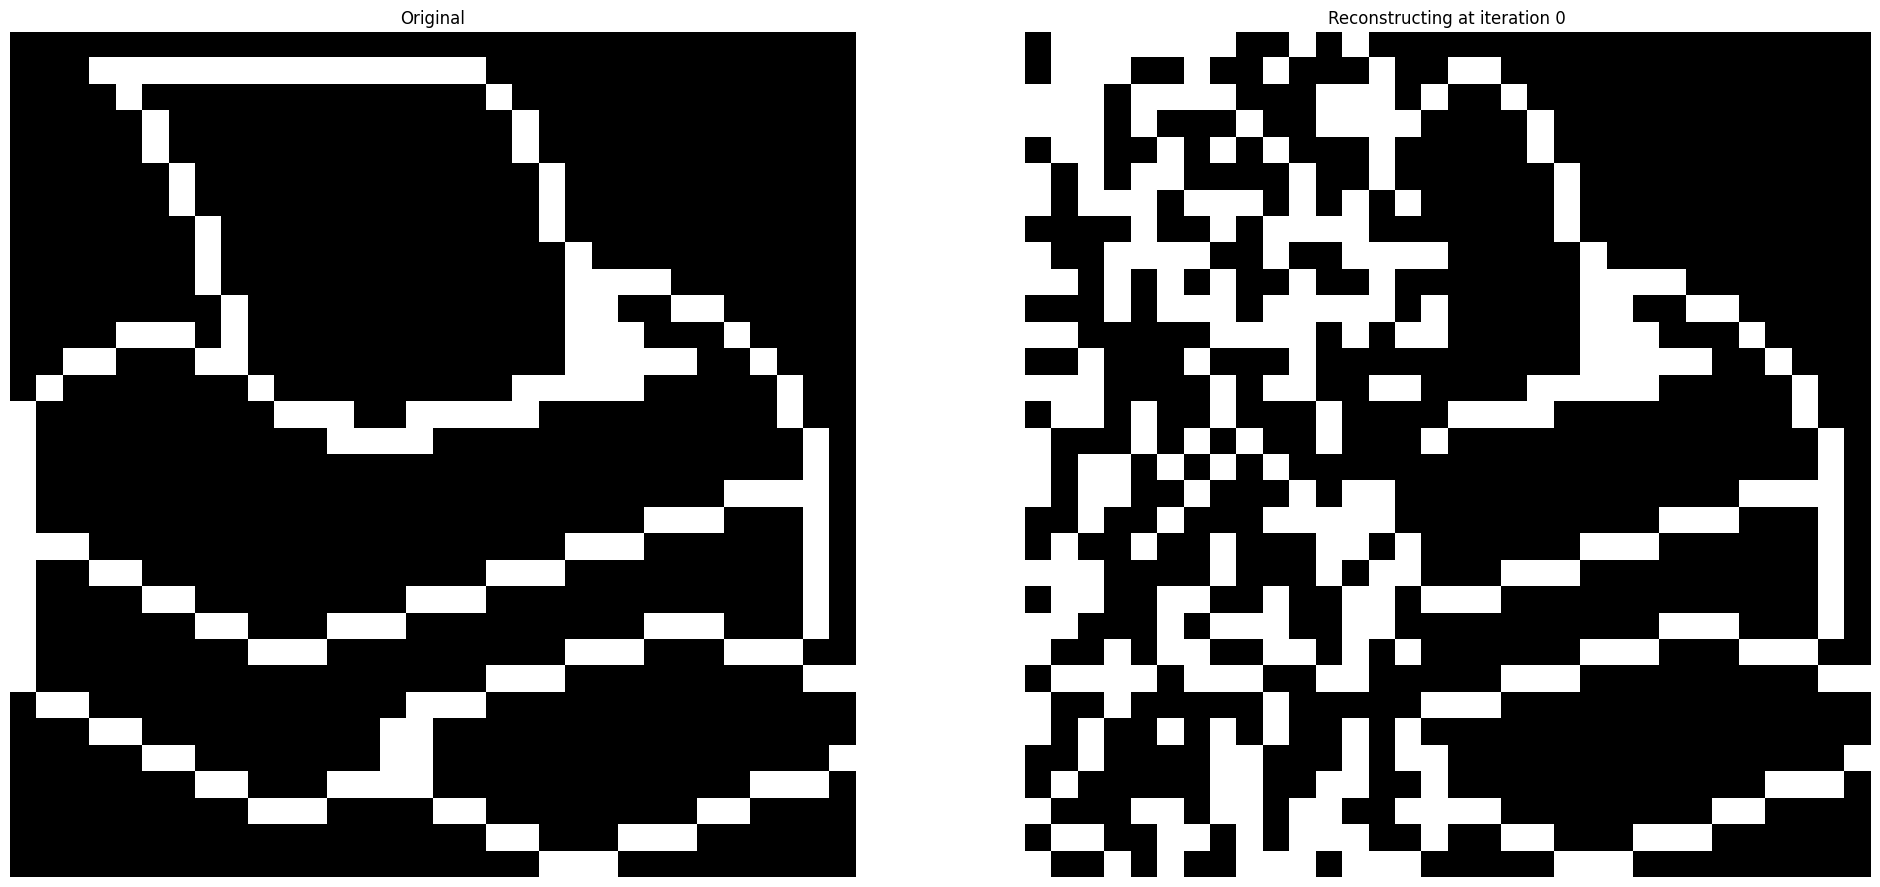

Iteration 2000


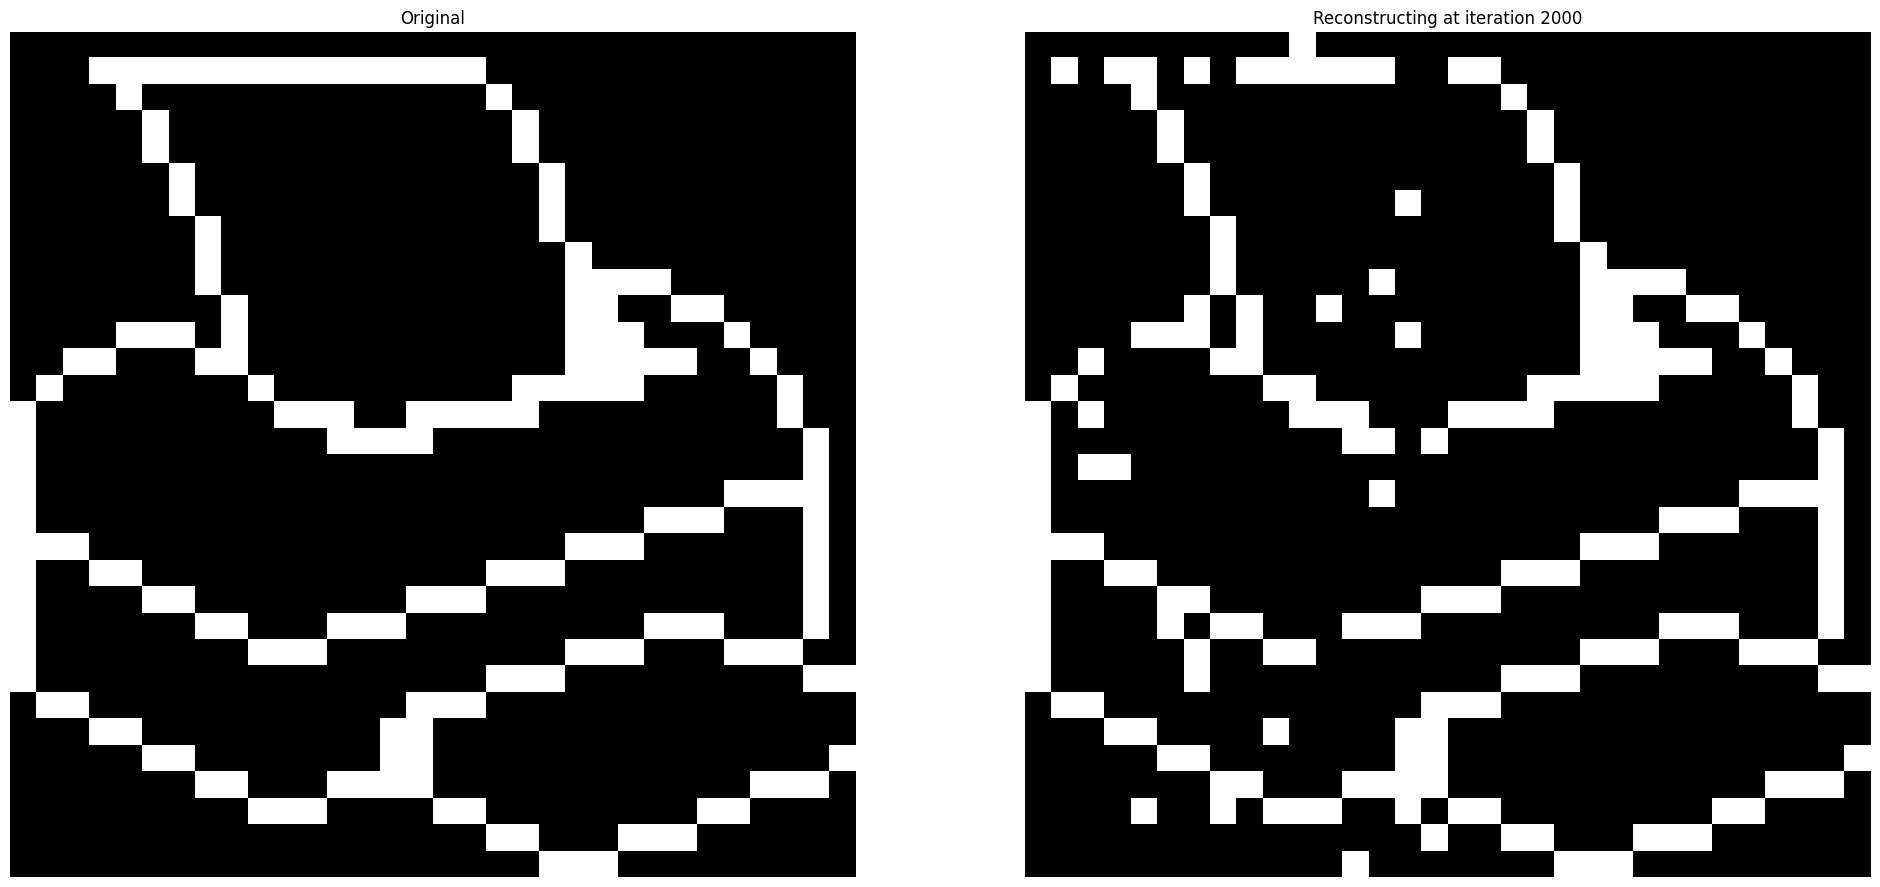

Iteration 4000


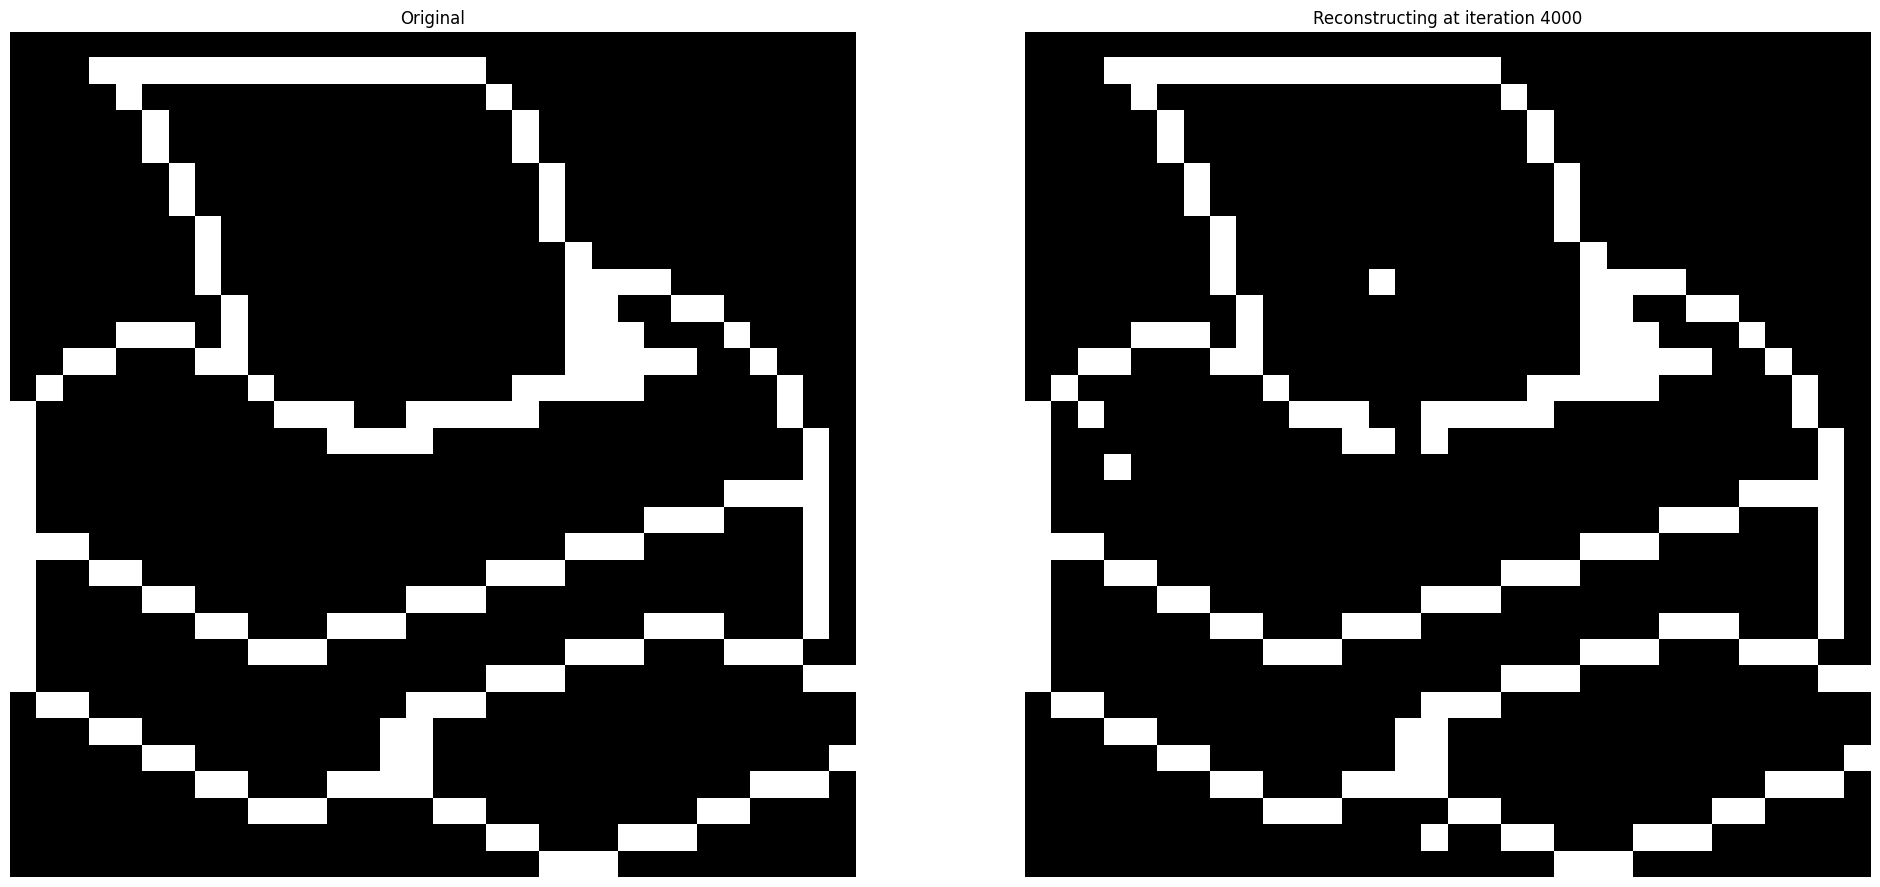

Iteration 6000


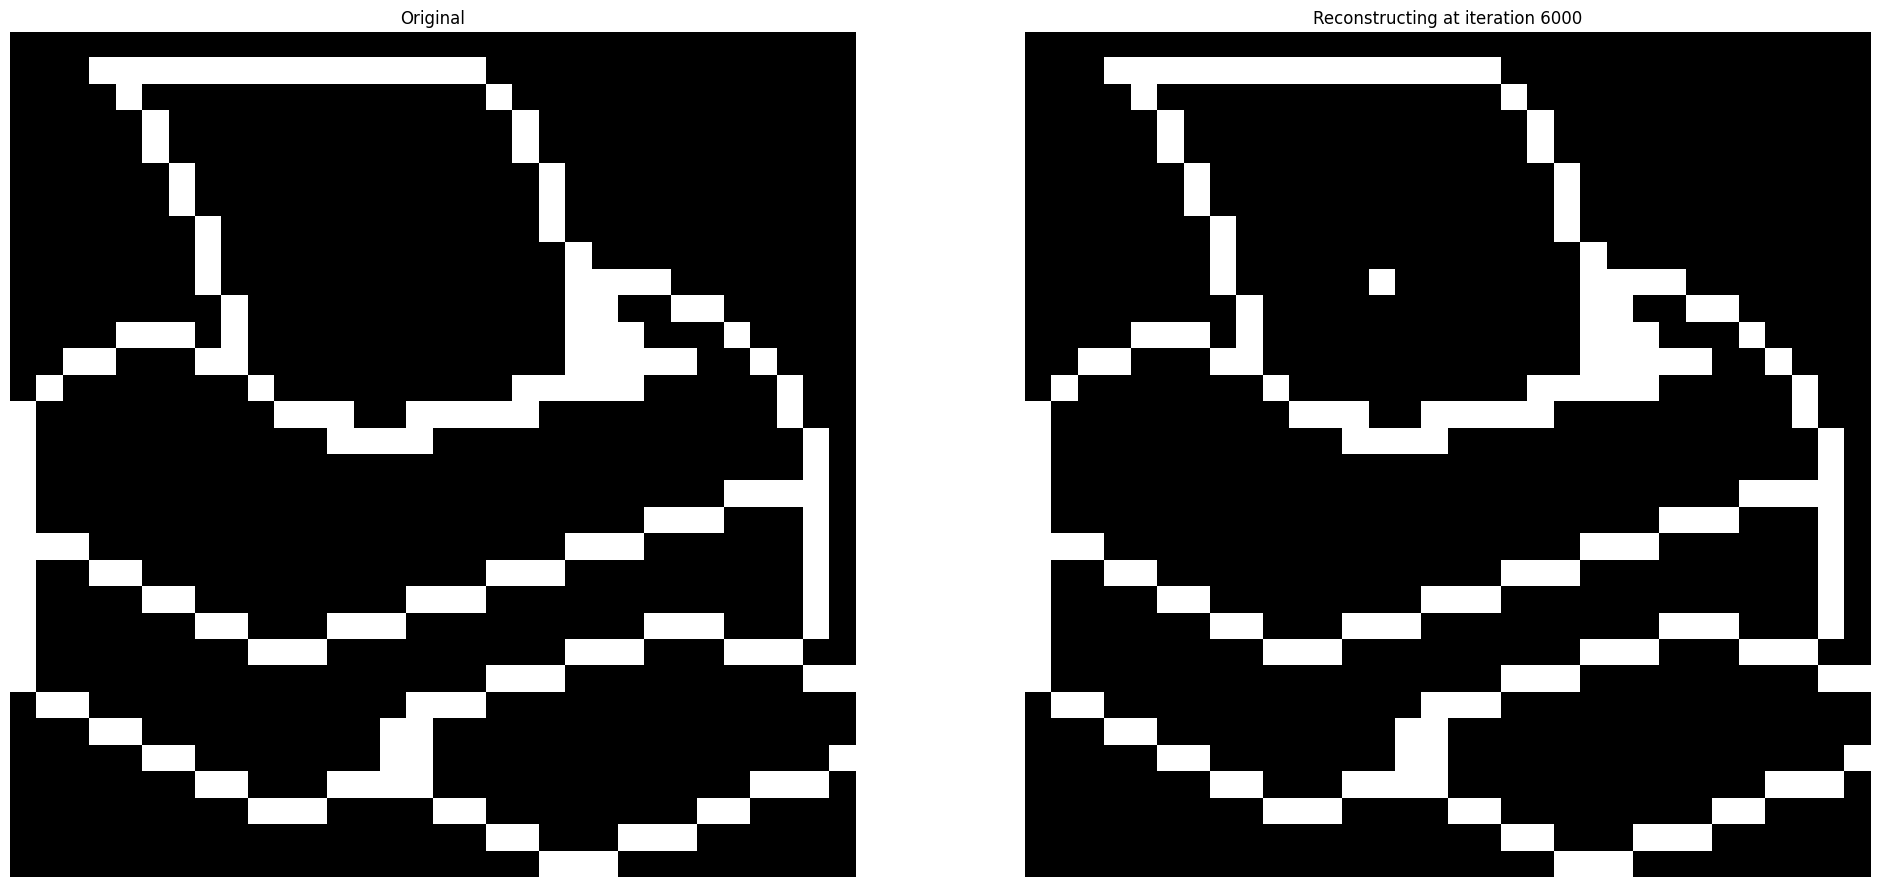

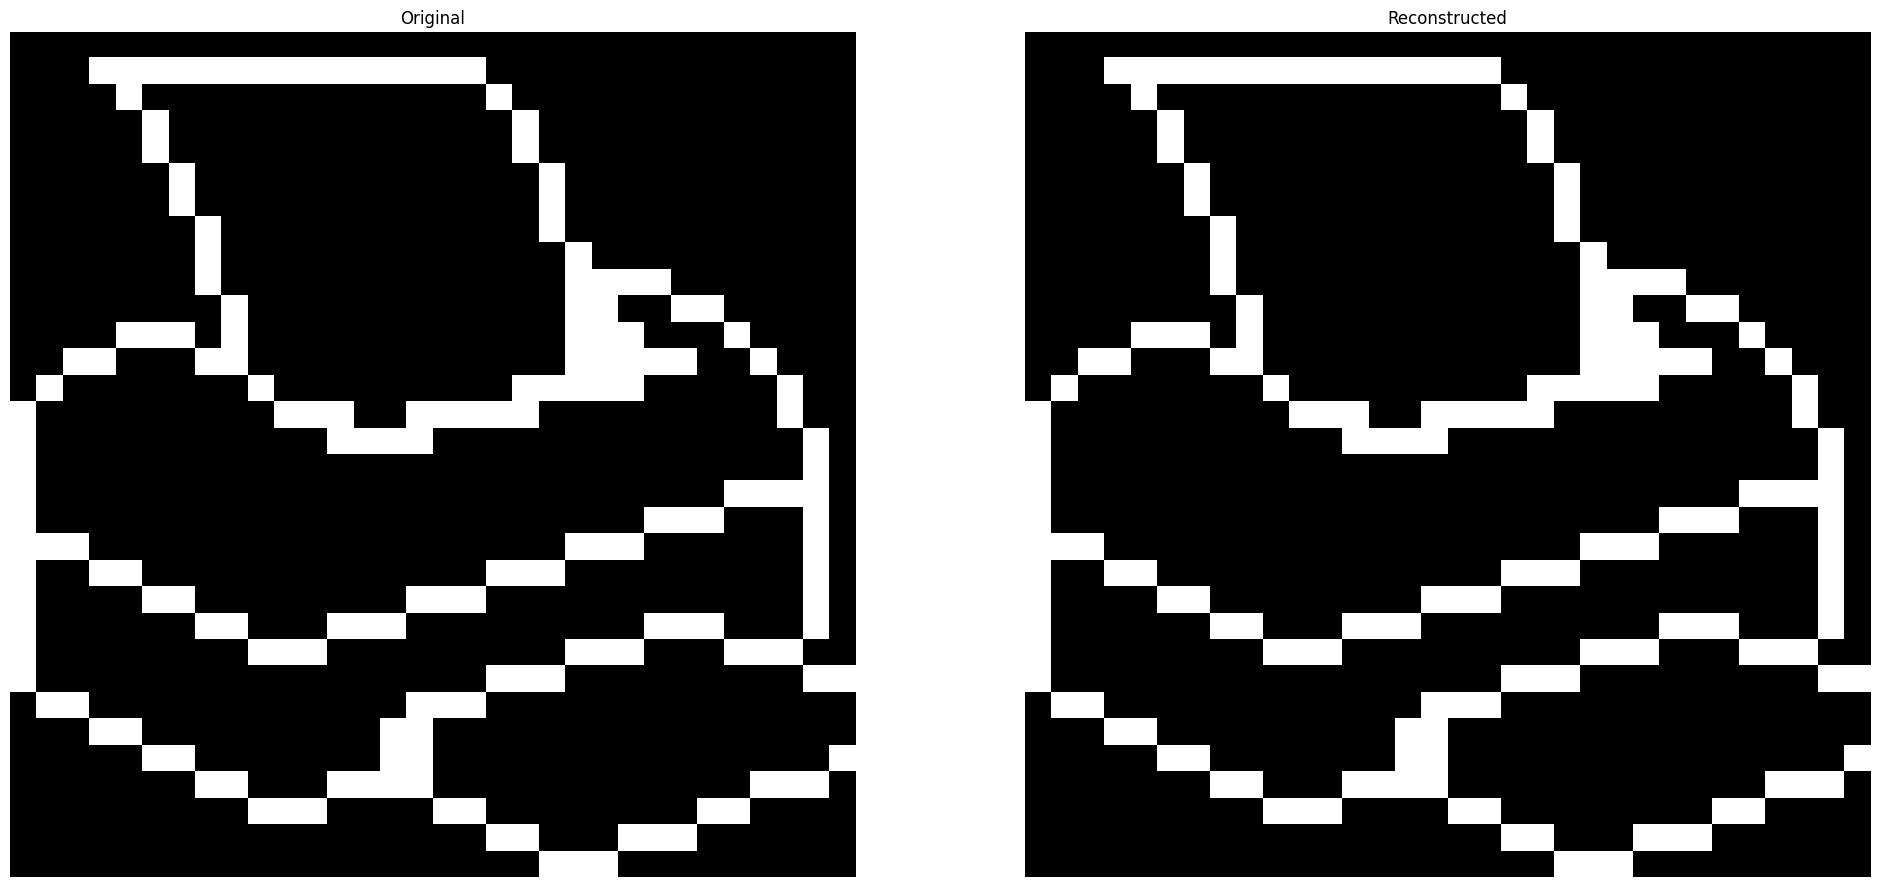

Iteration 0


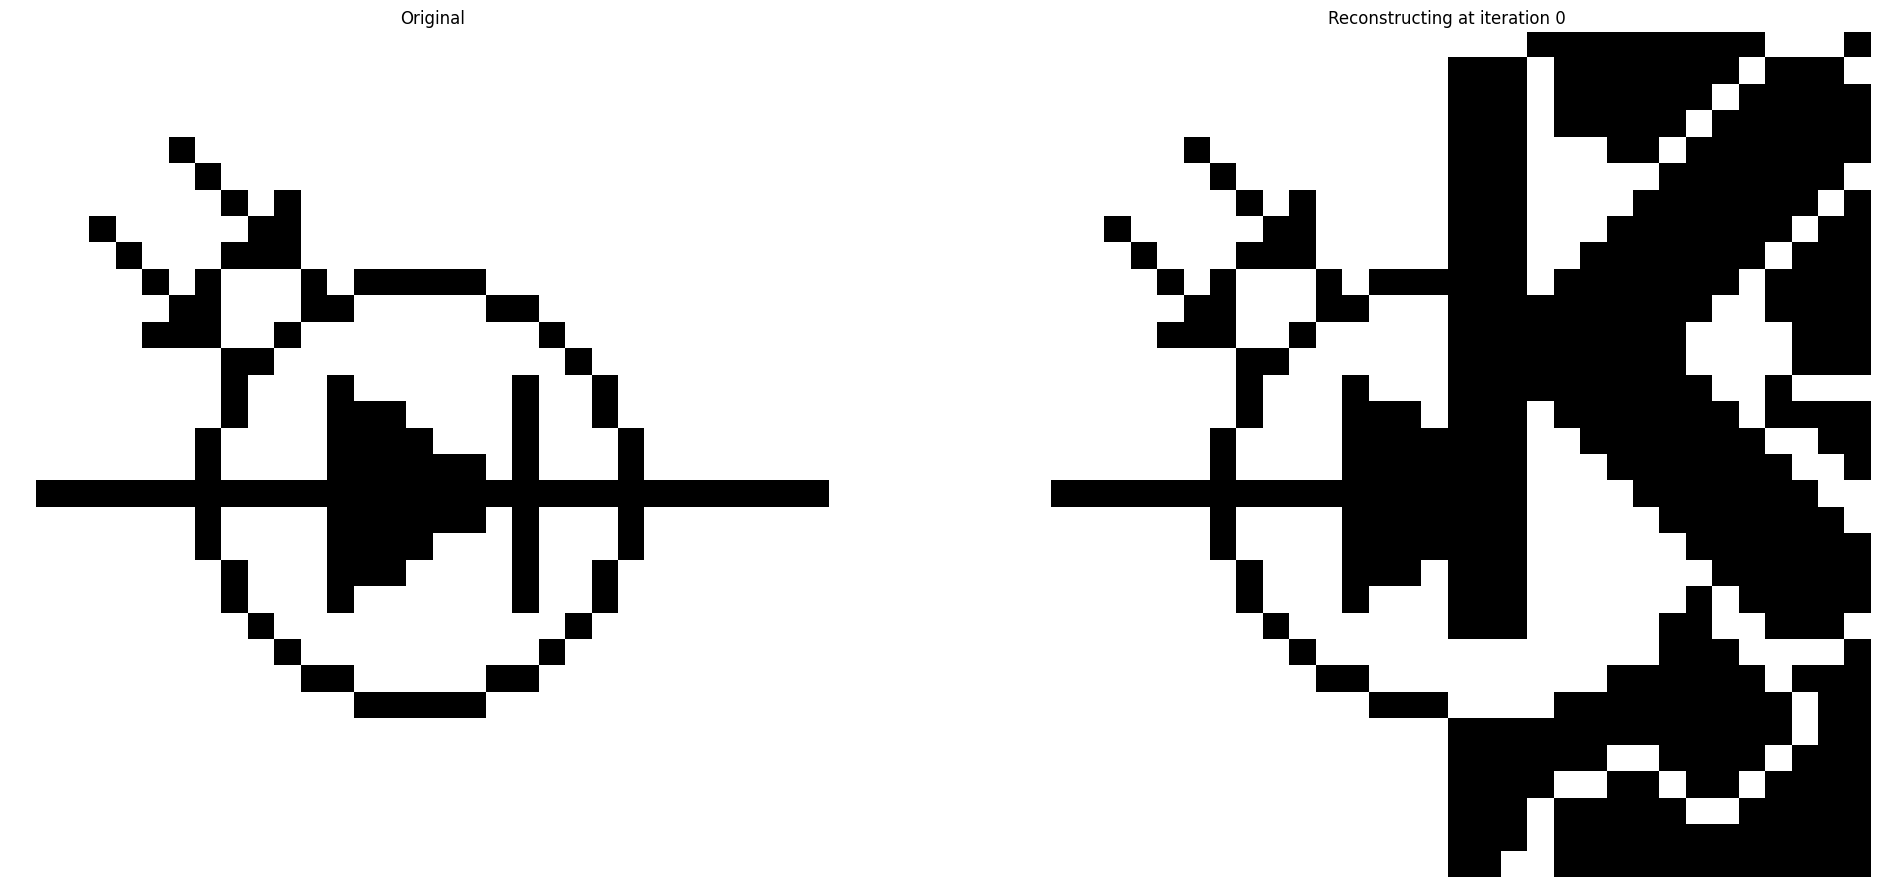

Iteration 2000


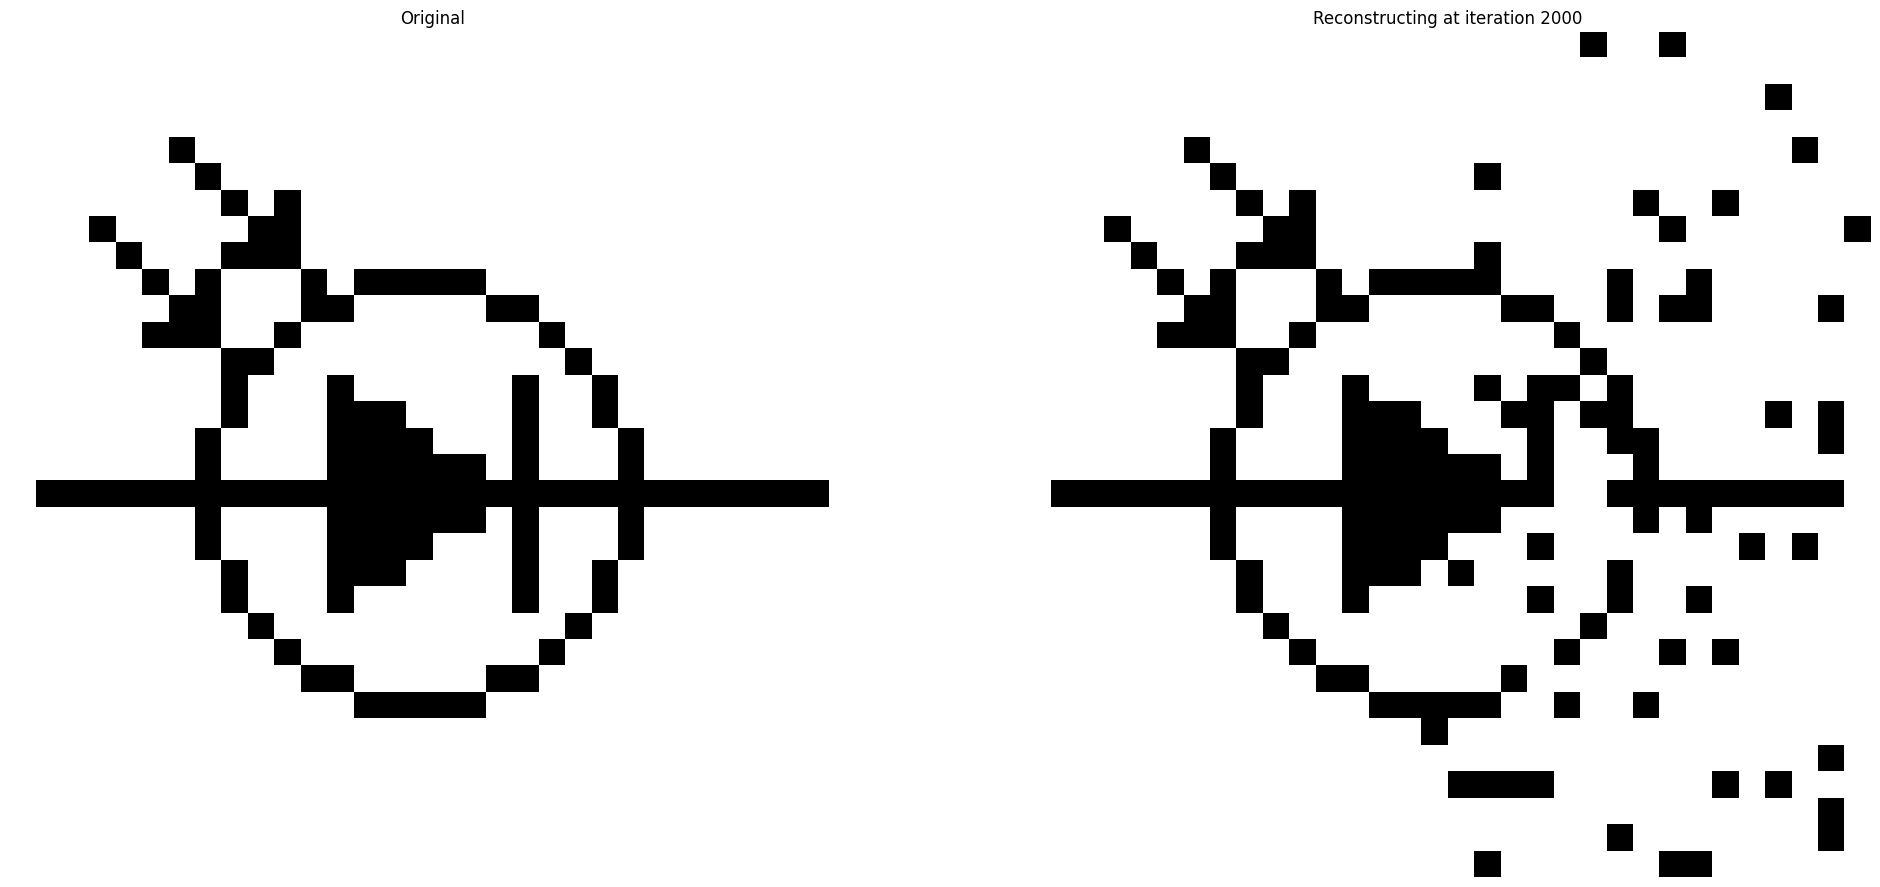

Iteration 4000


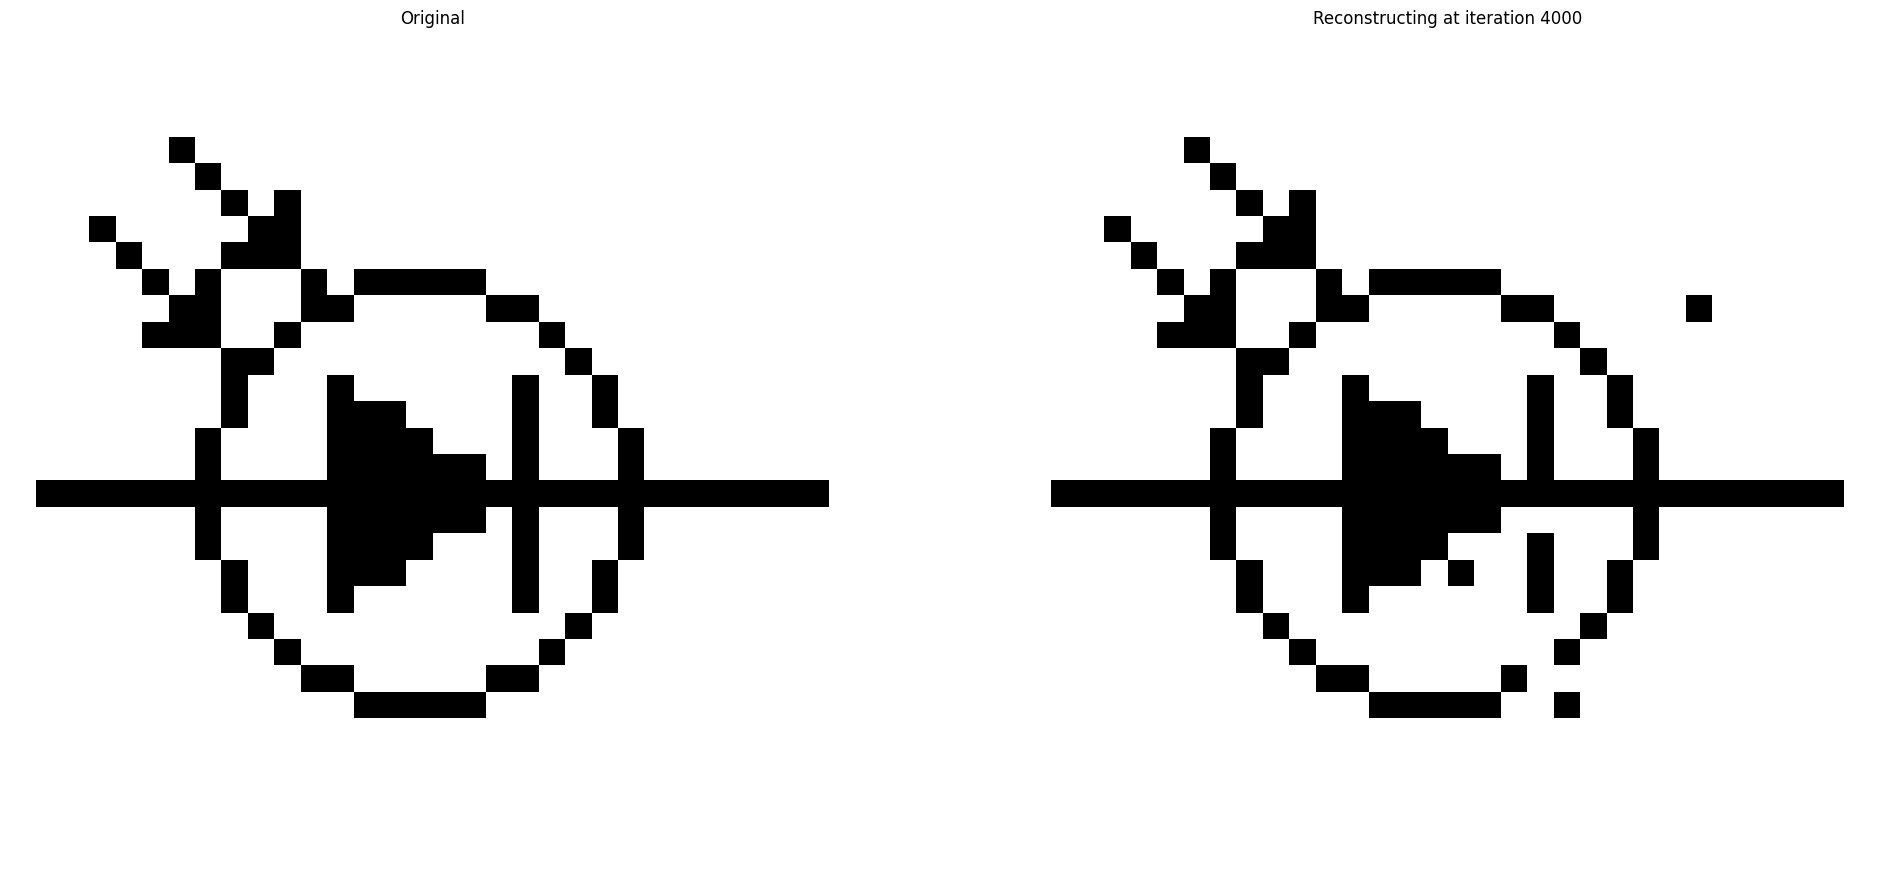

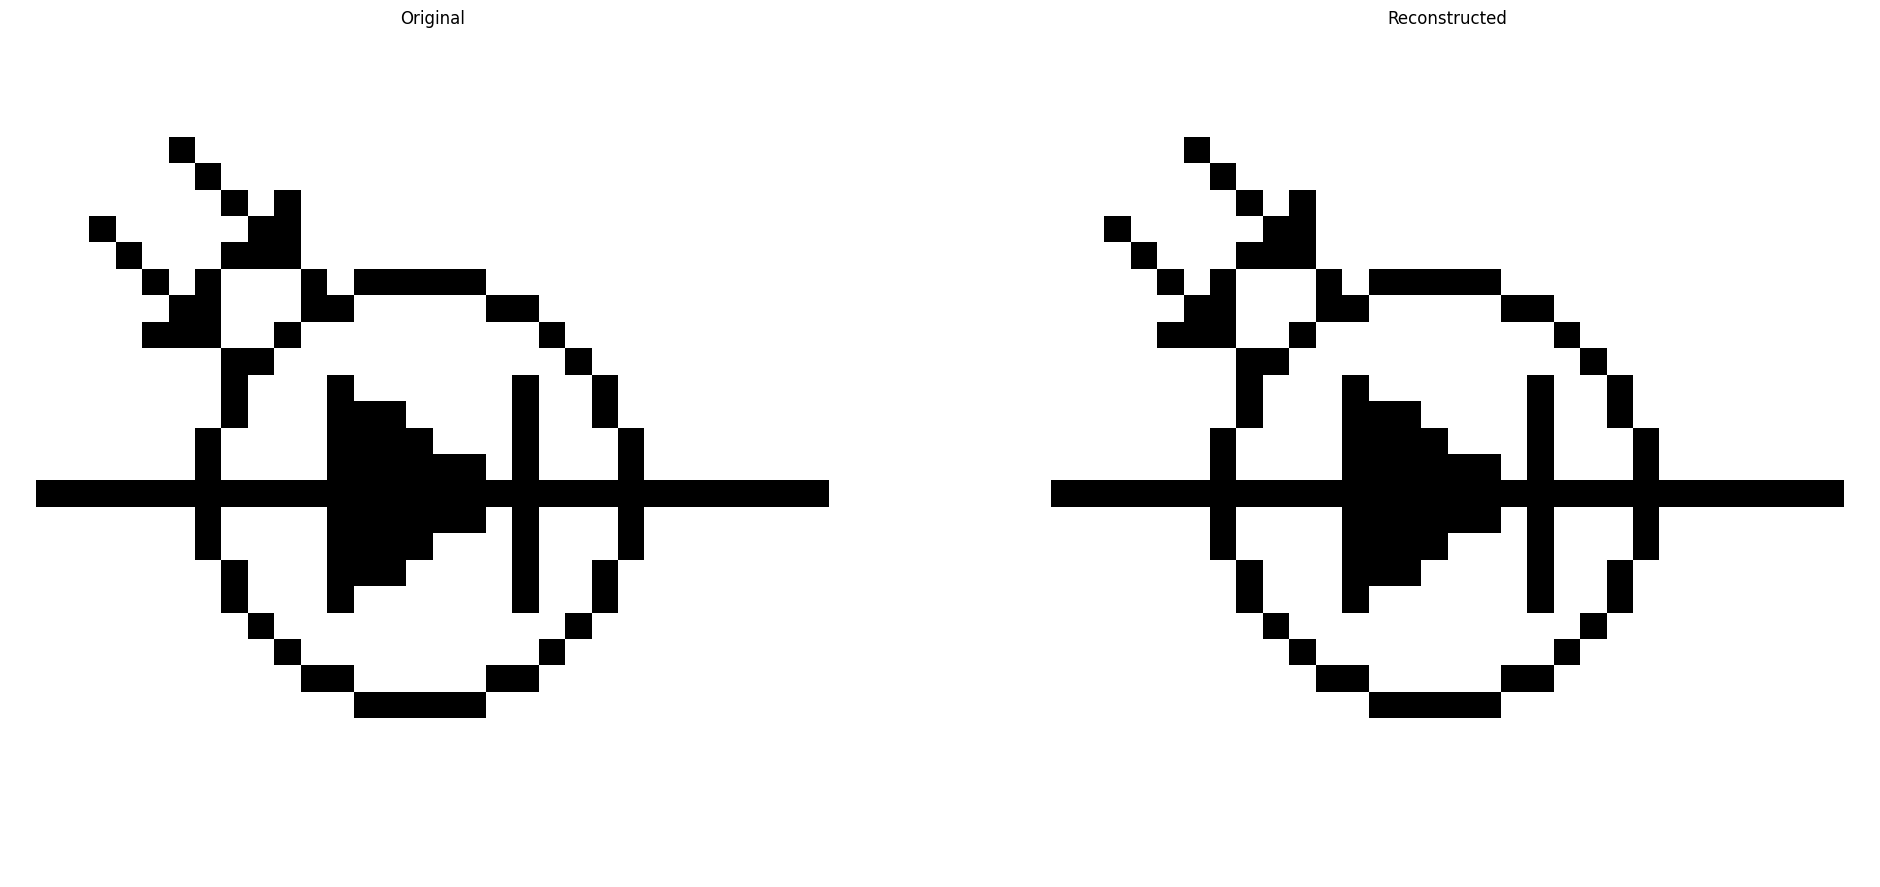

In [8]:
p10 = data[9].clone()
p11 = data[10].clone()
predicted_p10 = hopfield_seq.predict_asynchronous(p10, p1)
predicted_p11 = hopfield_seq.predict_asynchronous(p11, p3)

> The image that was not converging before converge now in one of the mixed patterns.


## 3.3 - Energy


In [9]:
for x in data[:9]:
    print(hopfield_seq.energy(x))

tensor(-719.6953)
tensor(-682.8203)
tensor(-731.1250)
tensor(-360.2402)
tensor(-262.9453)
tensor(-341.6484)
tensor(-342.8652)
tensor(-85.7734)
tensor(-133.7559)


In [10]:
for x in data[9:]:
    print(hopfield_seq.energy(x))

tensor(-207.9902)
tensor(-86.7500)


Iteration 0


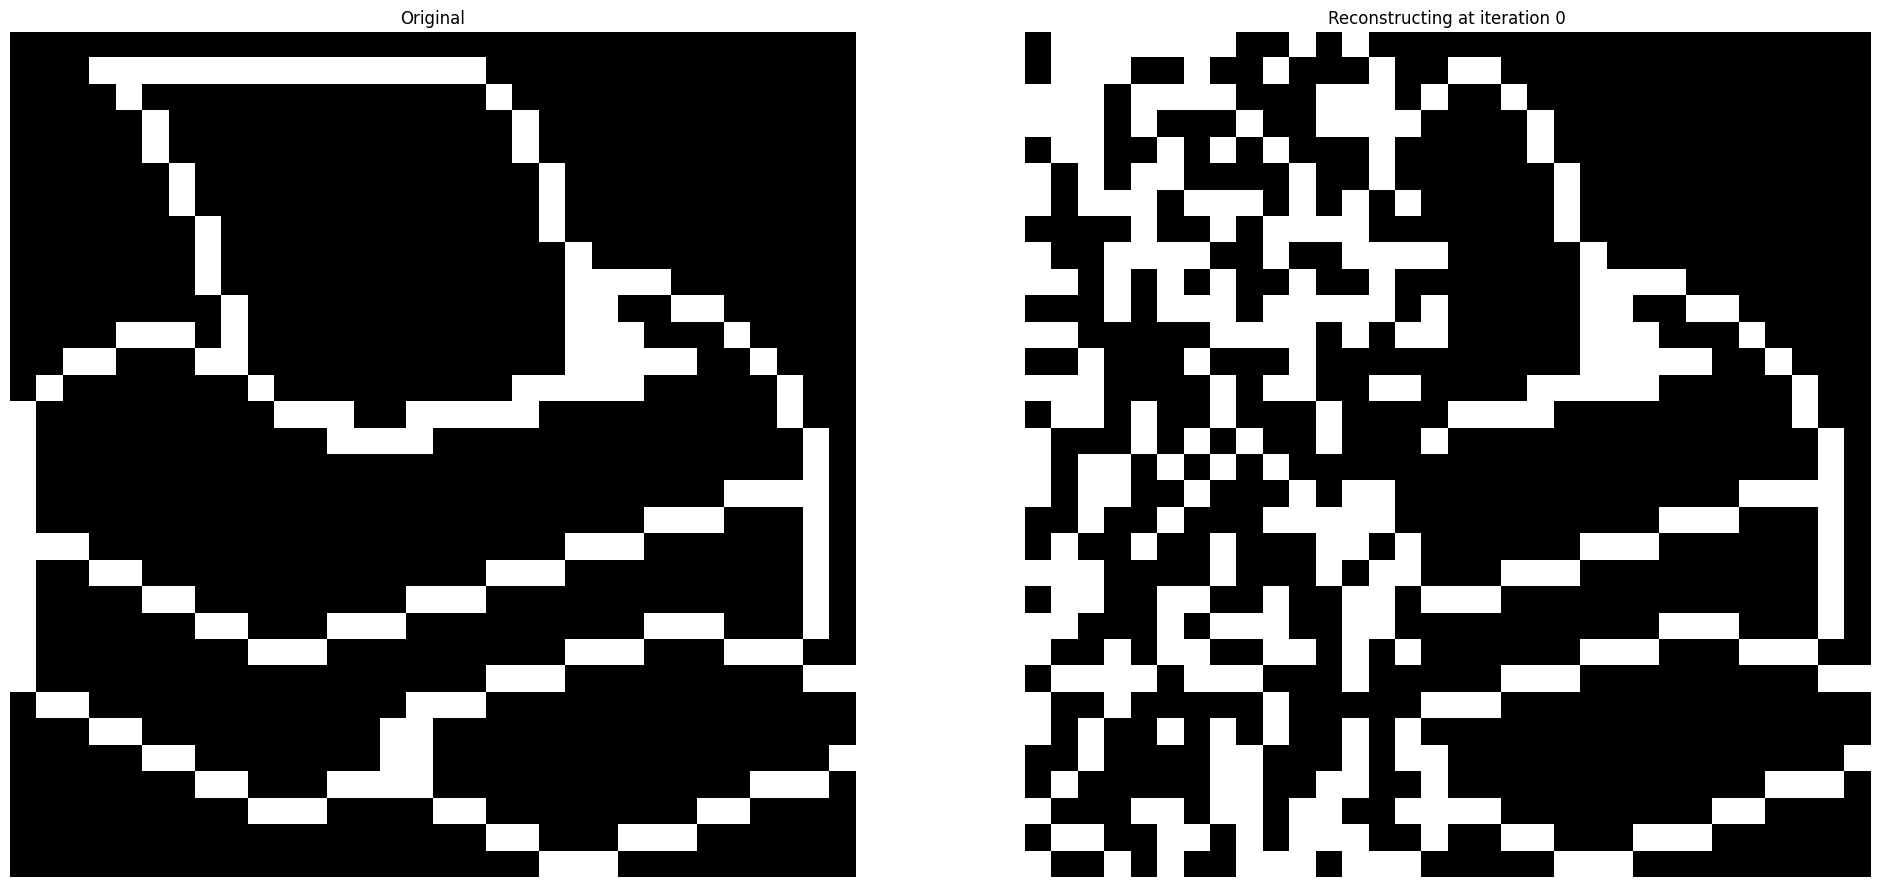

Iteration 2000


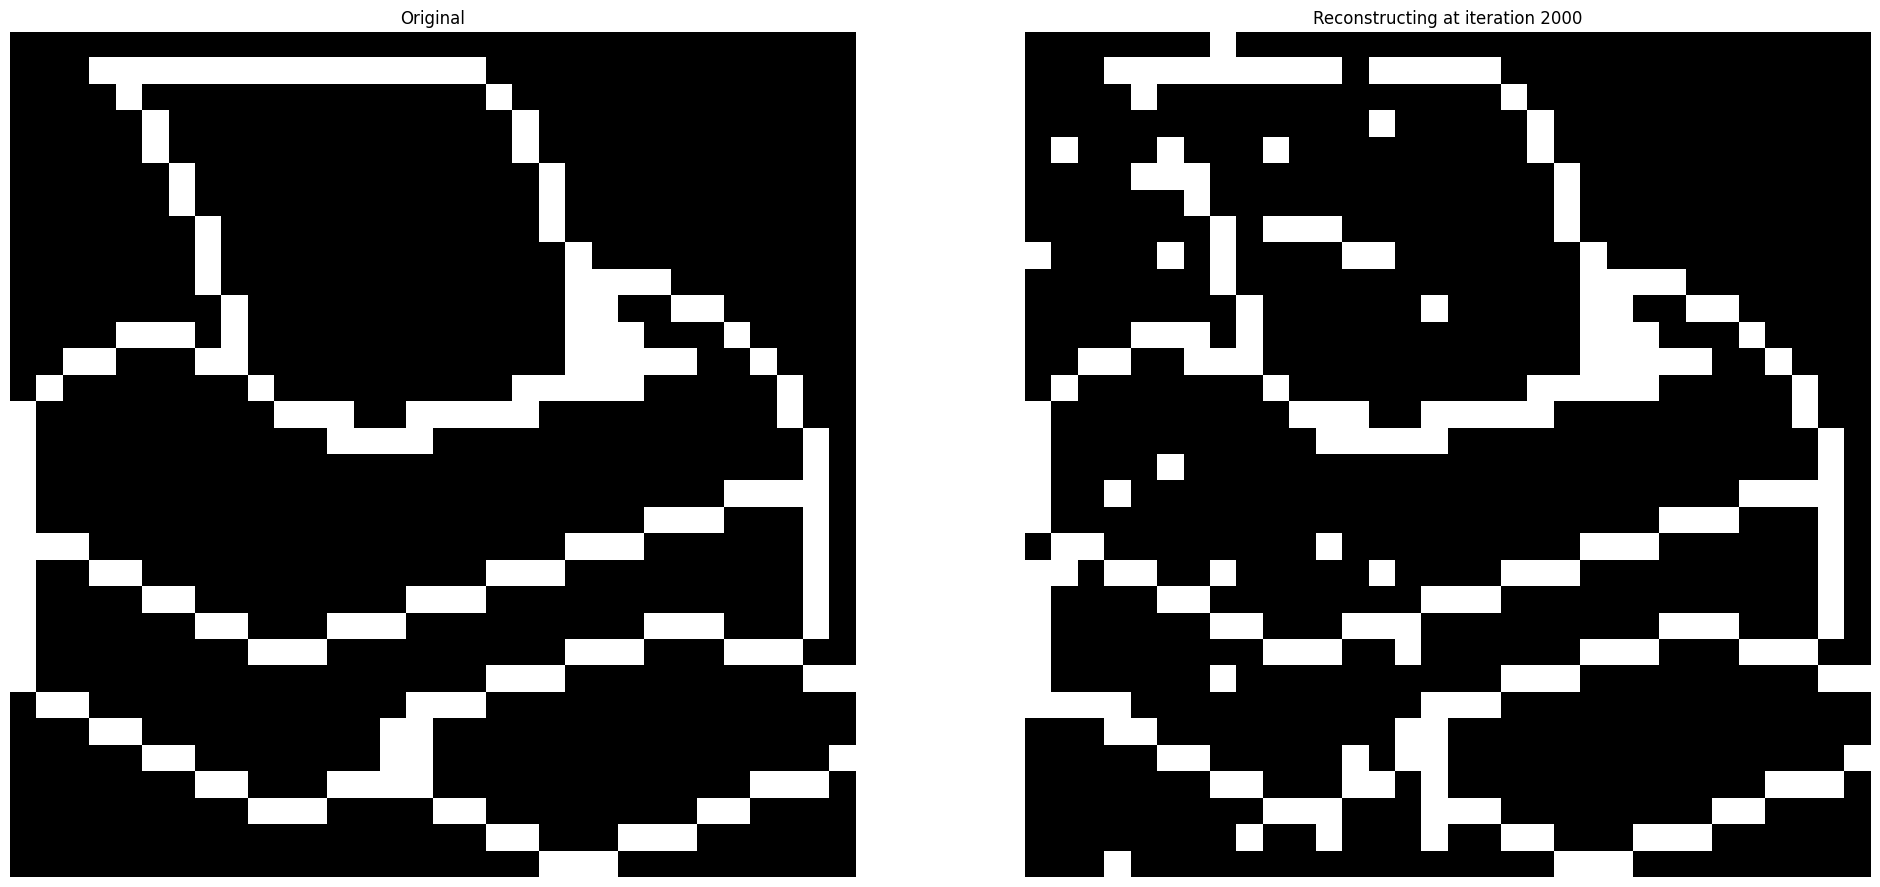

Iteration 4000


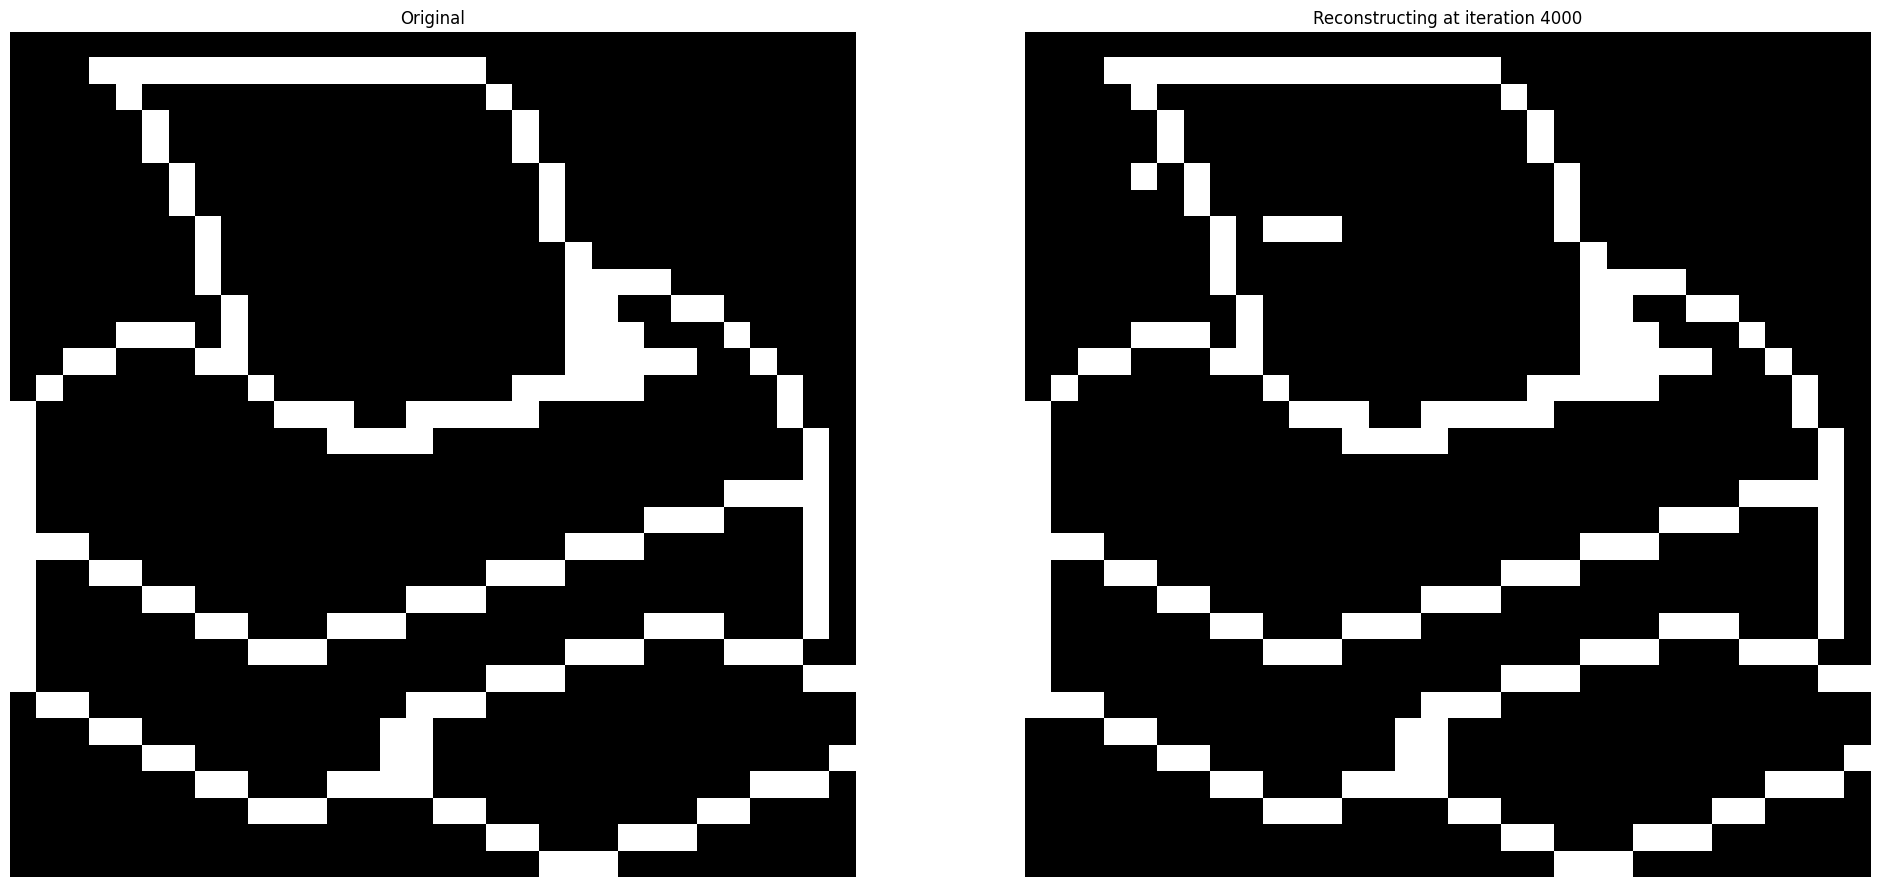

Iteration 6000


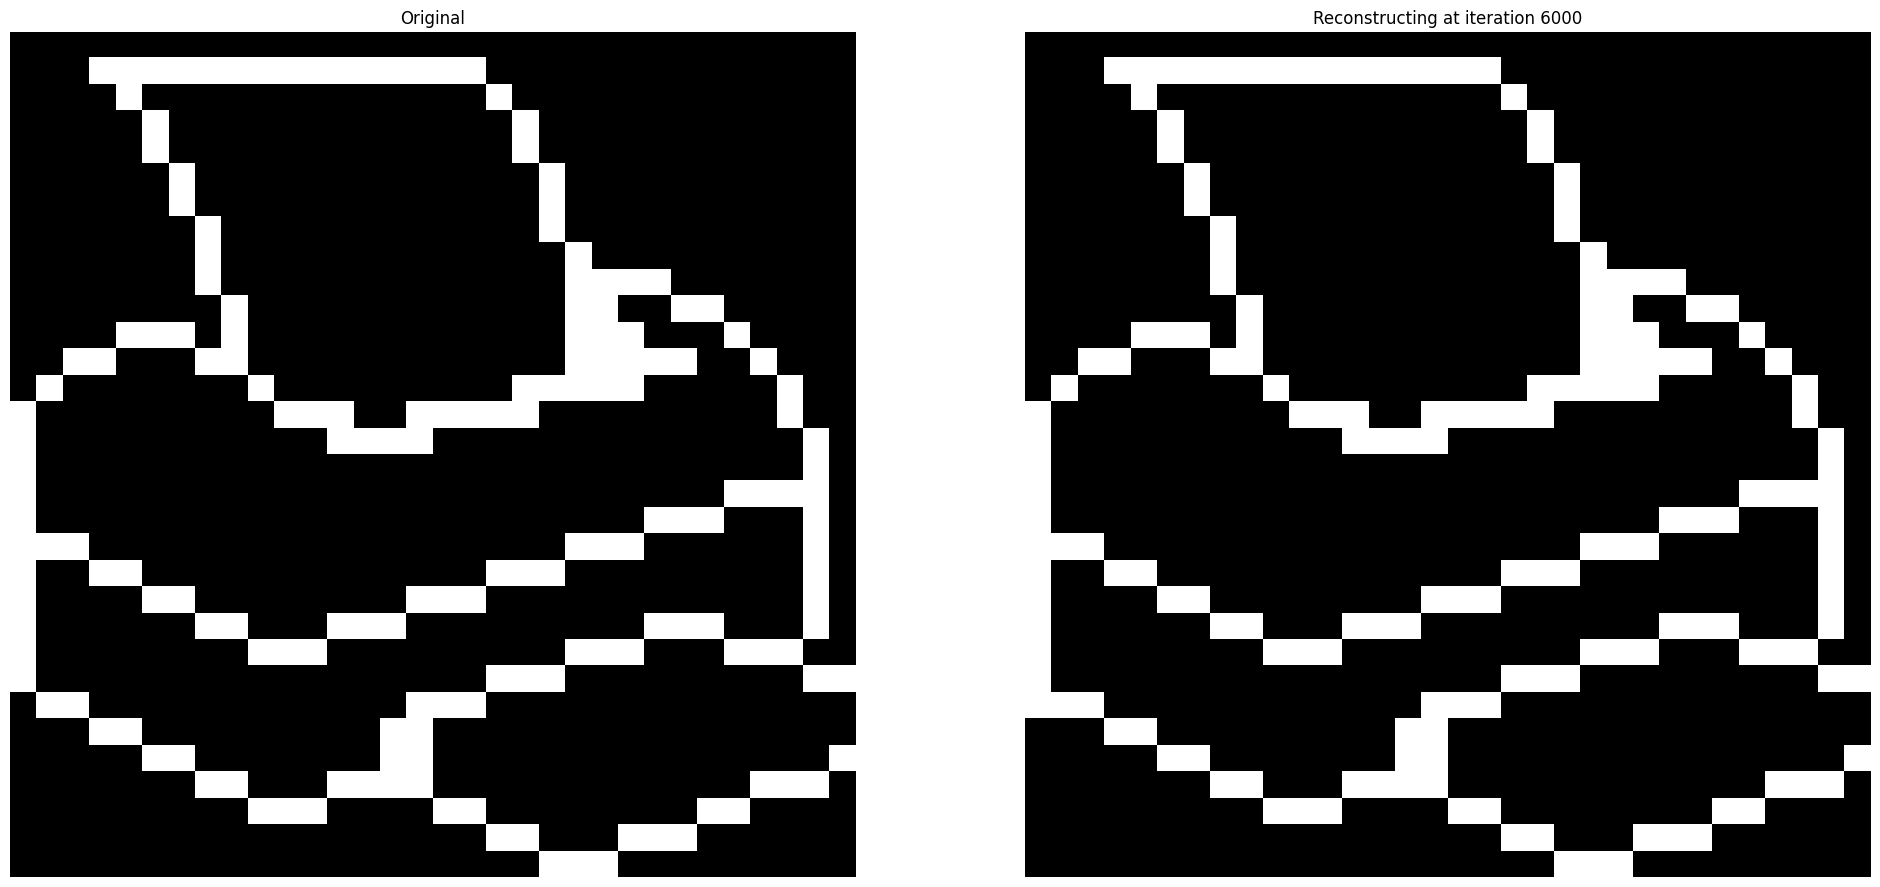

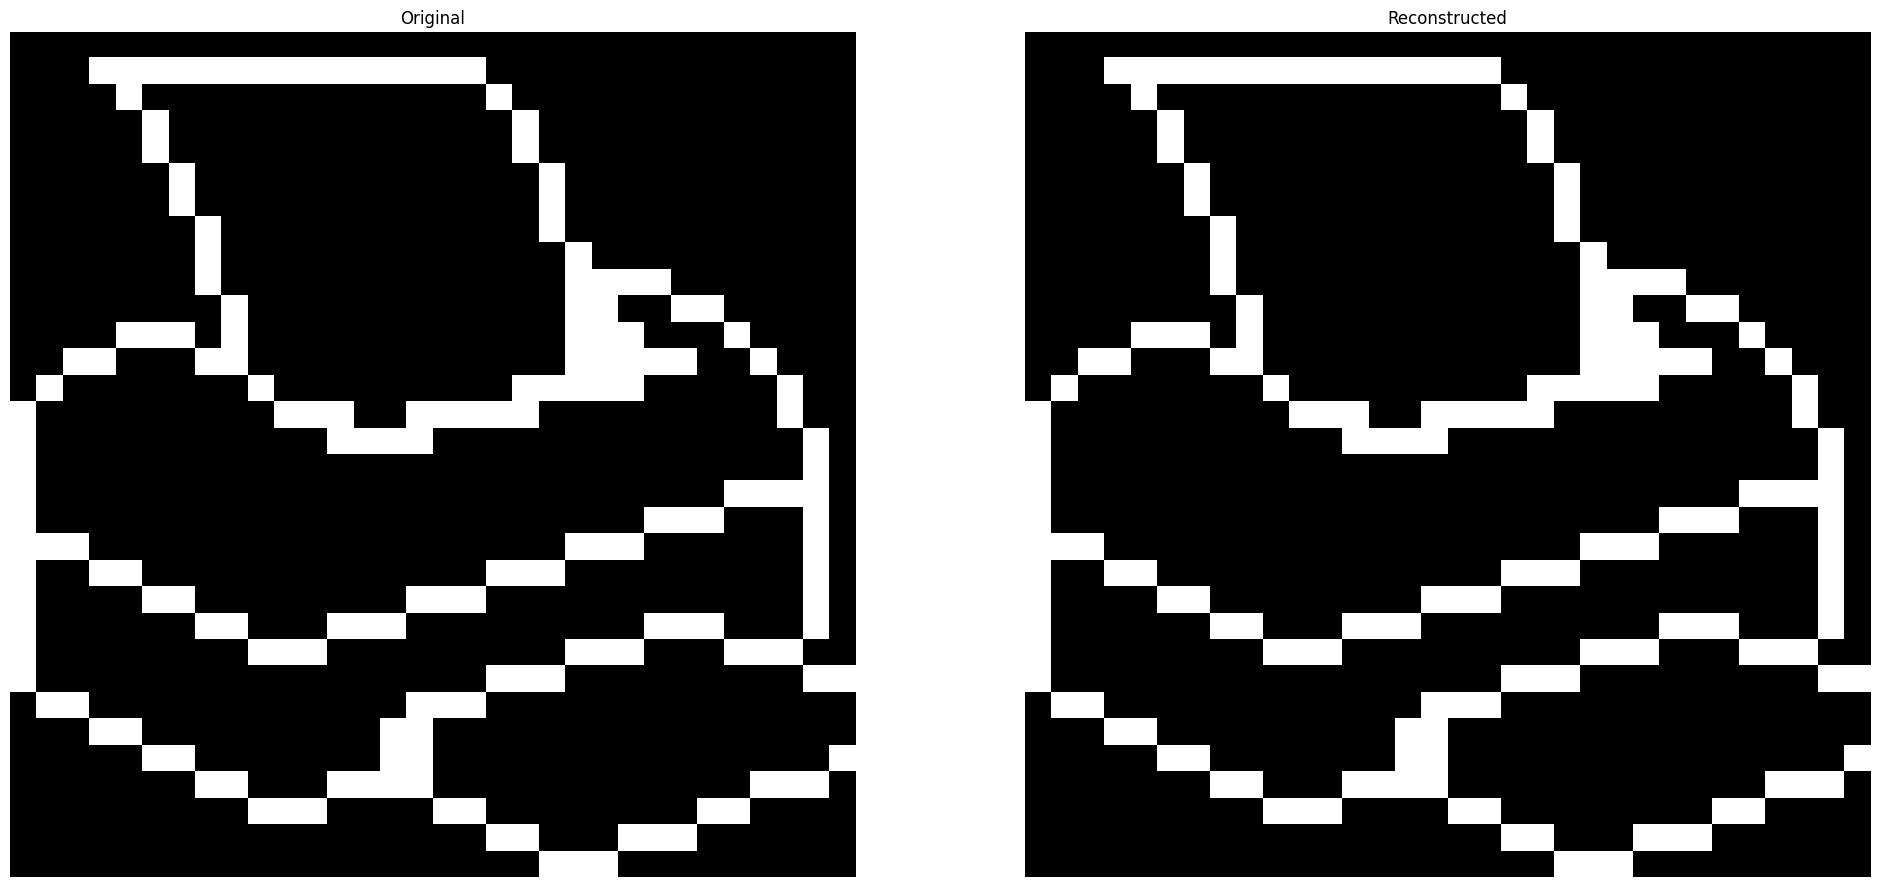

Iteration 0


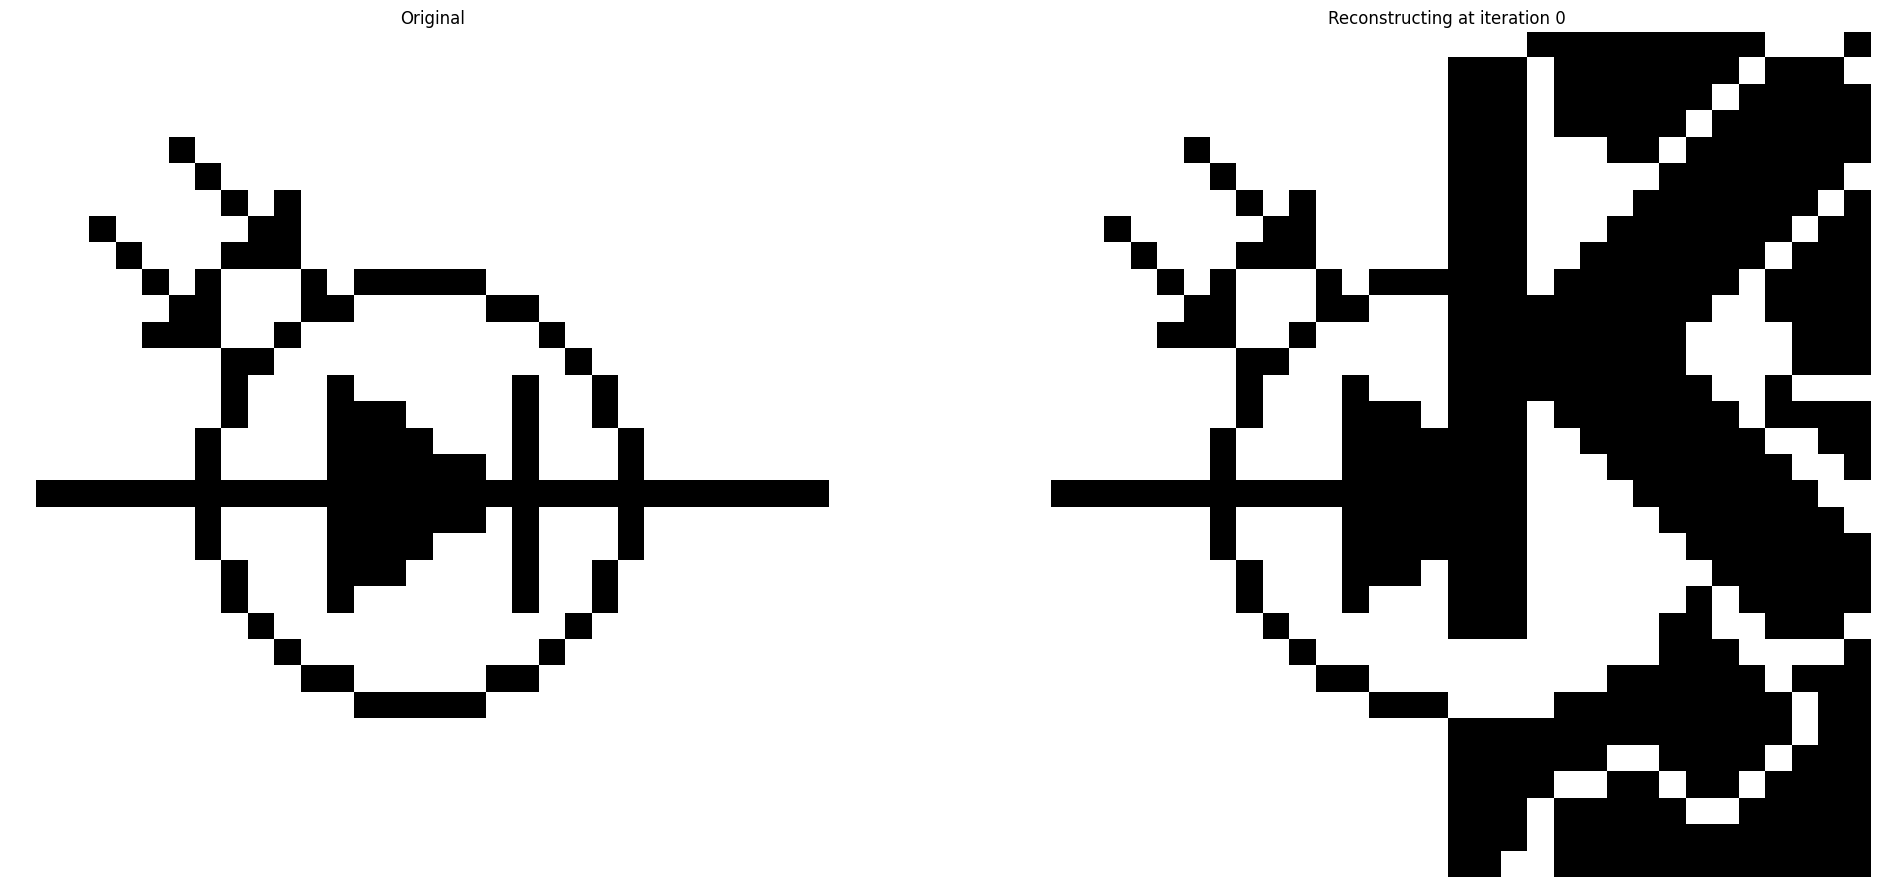

Iteration 2000


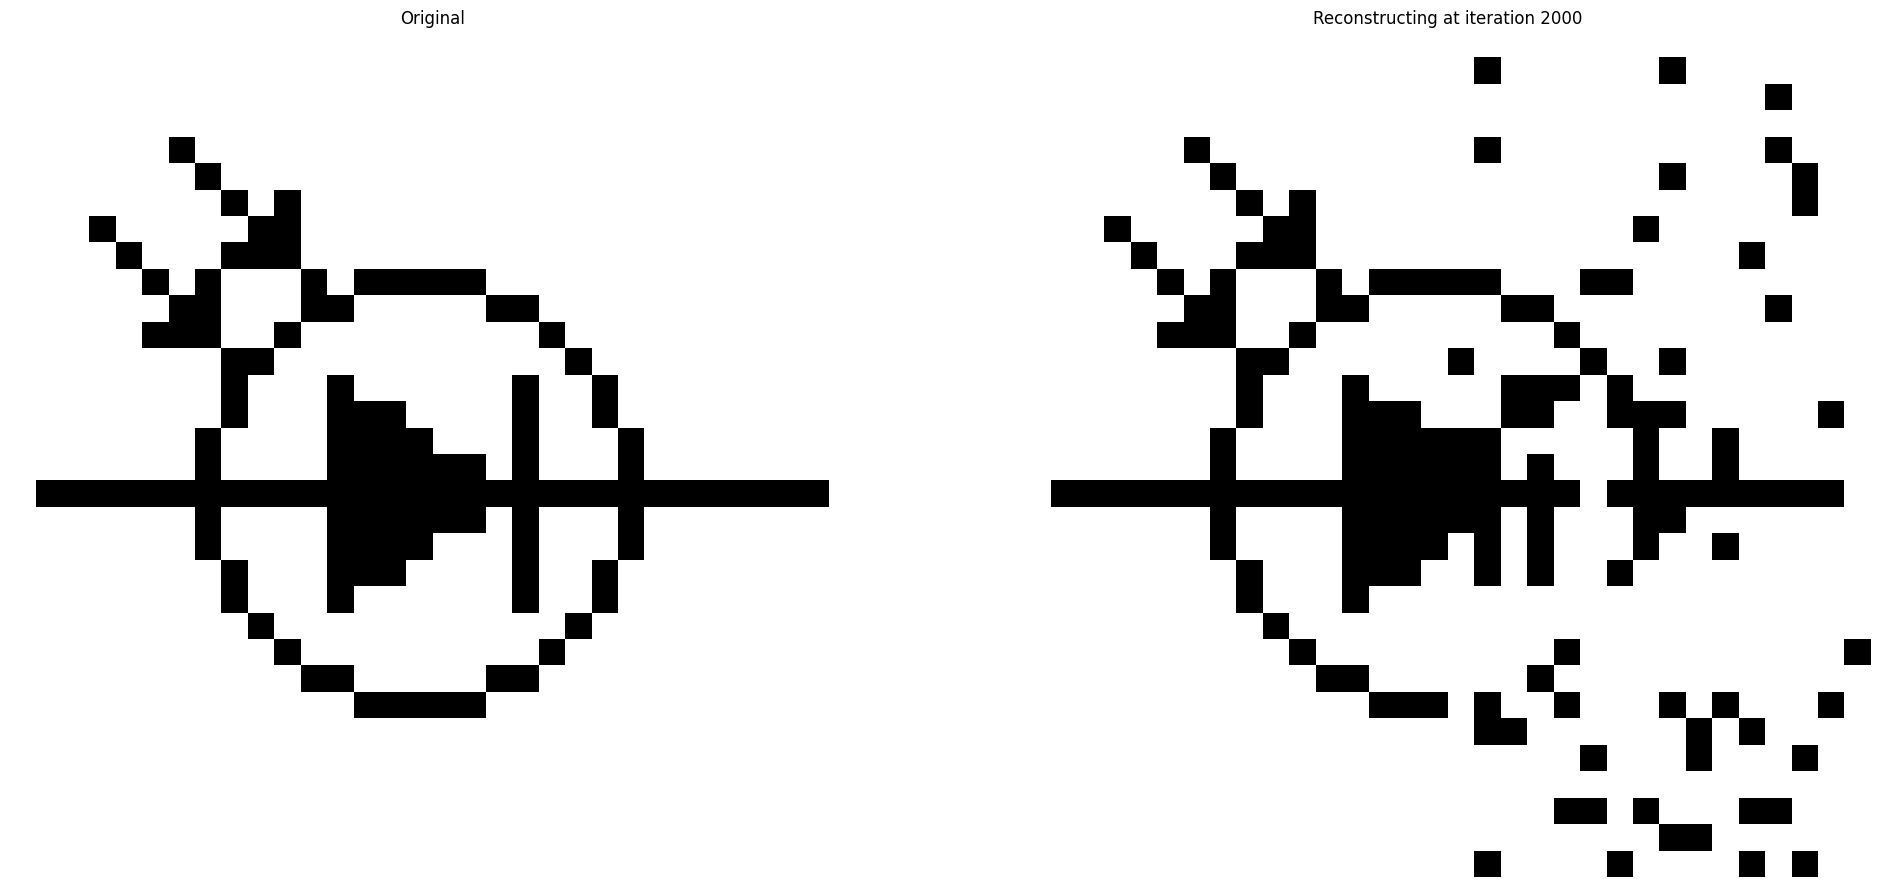

Iteration 4000


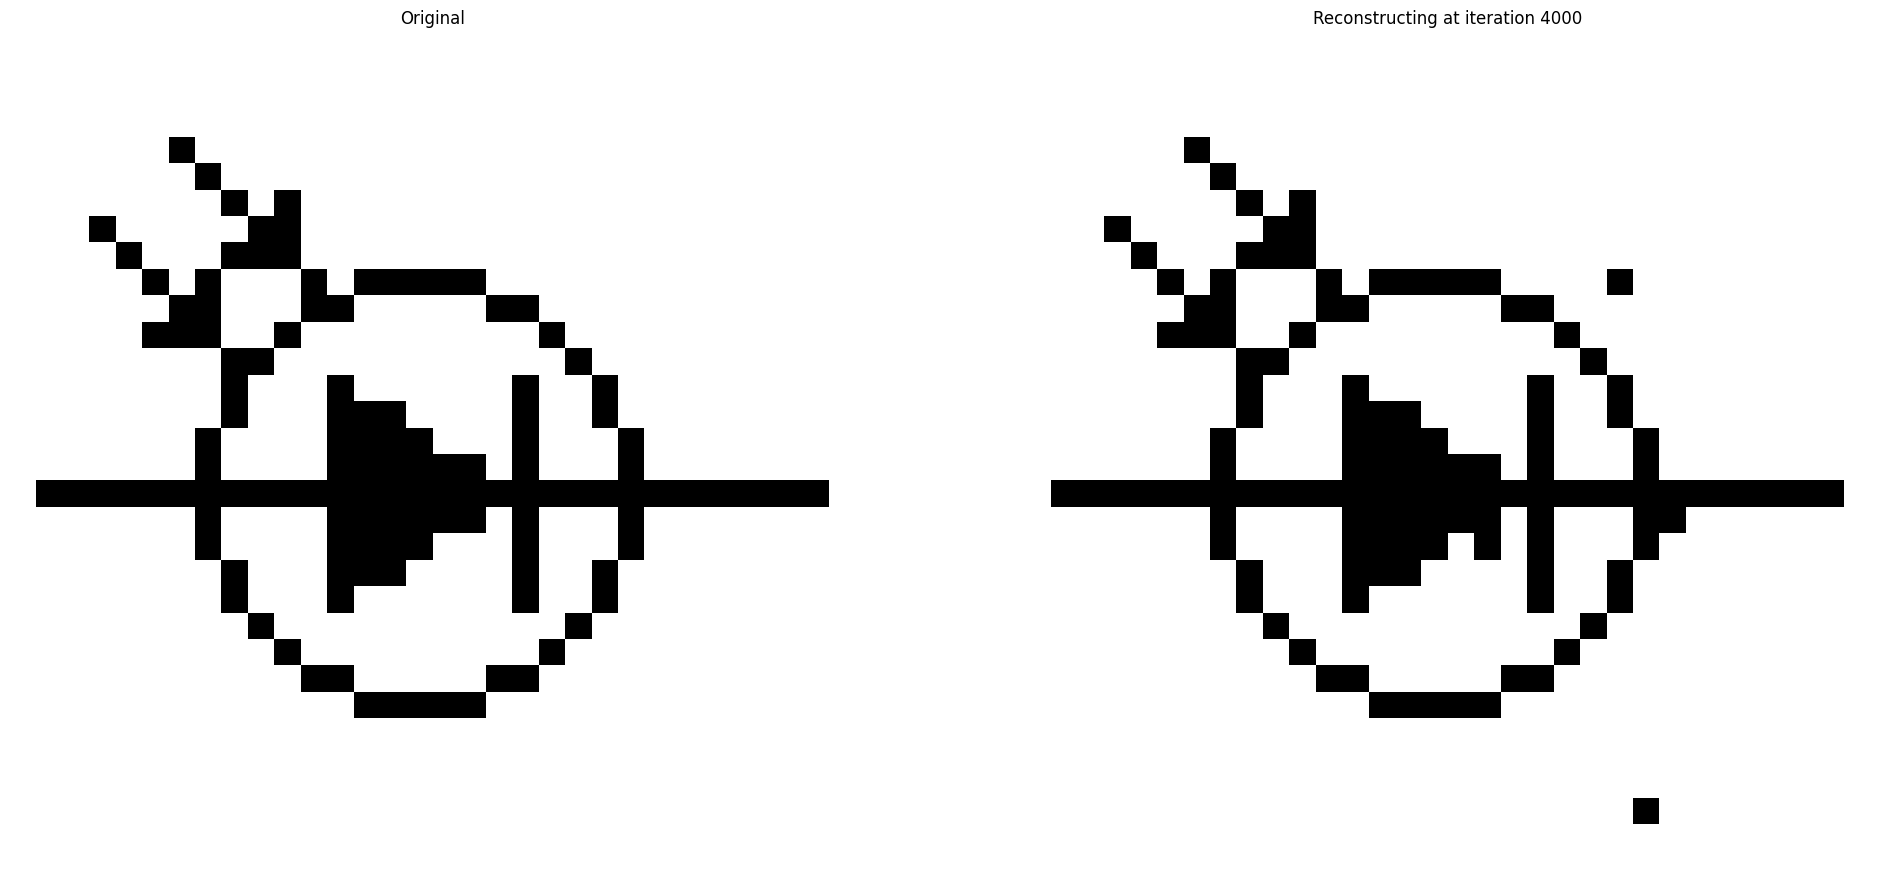

Iteration 6000


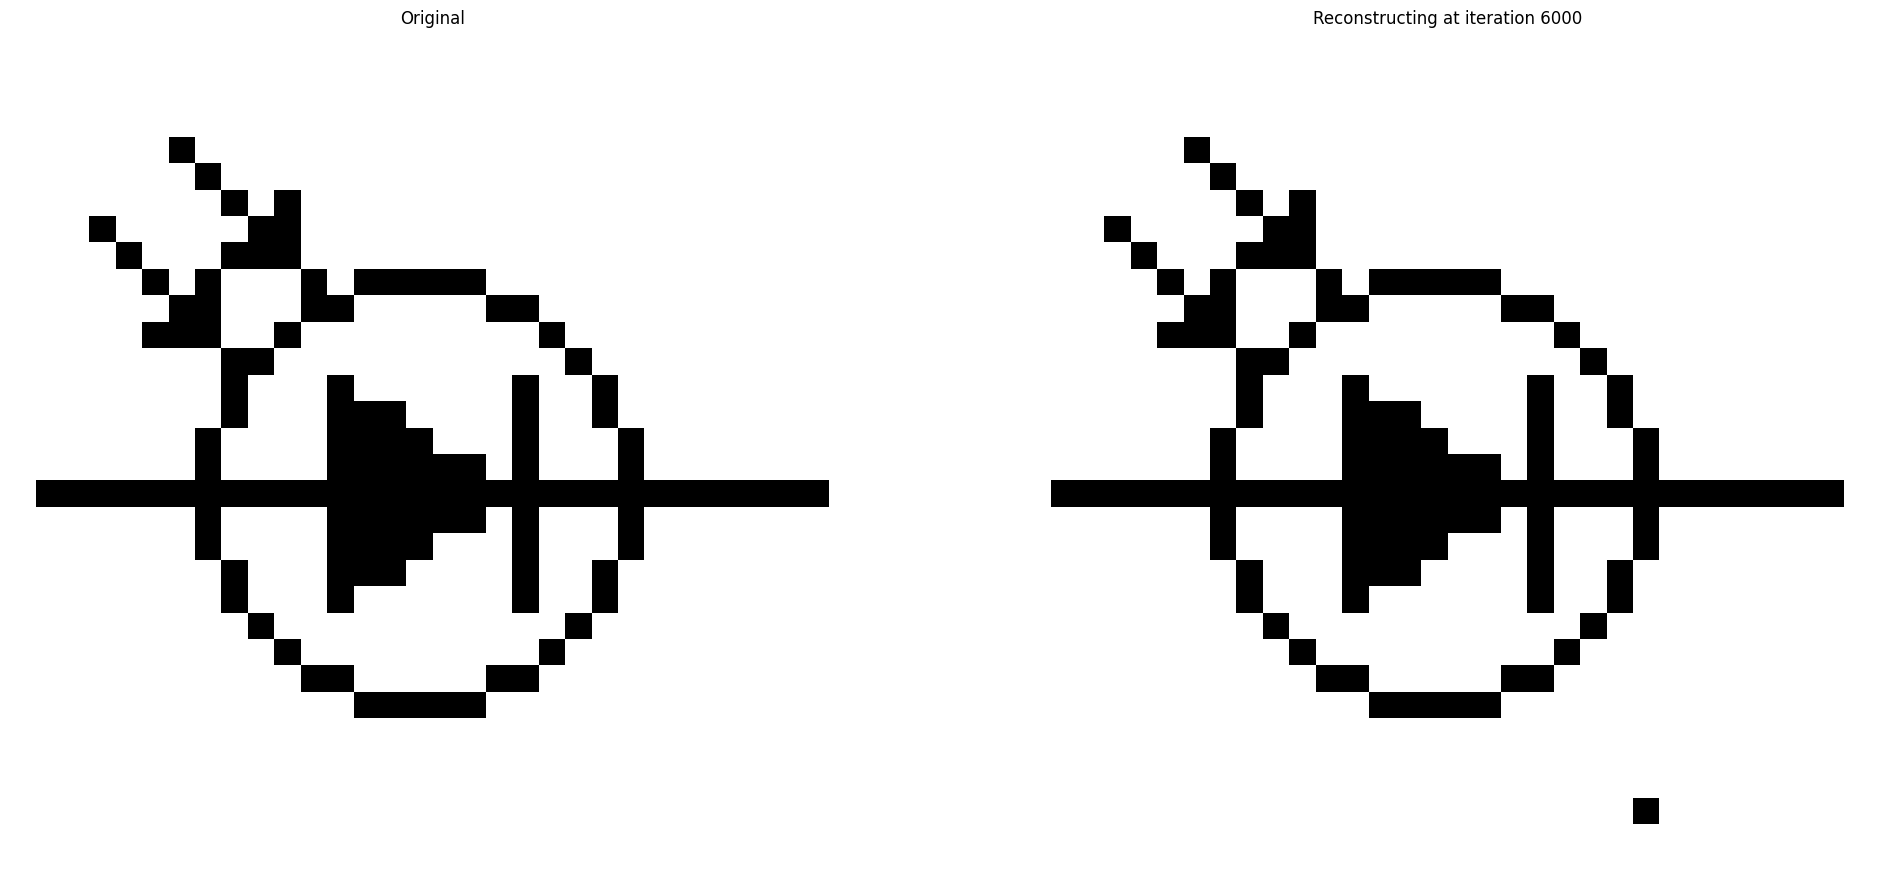

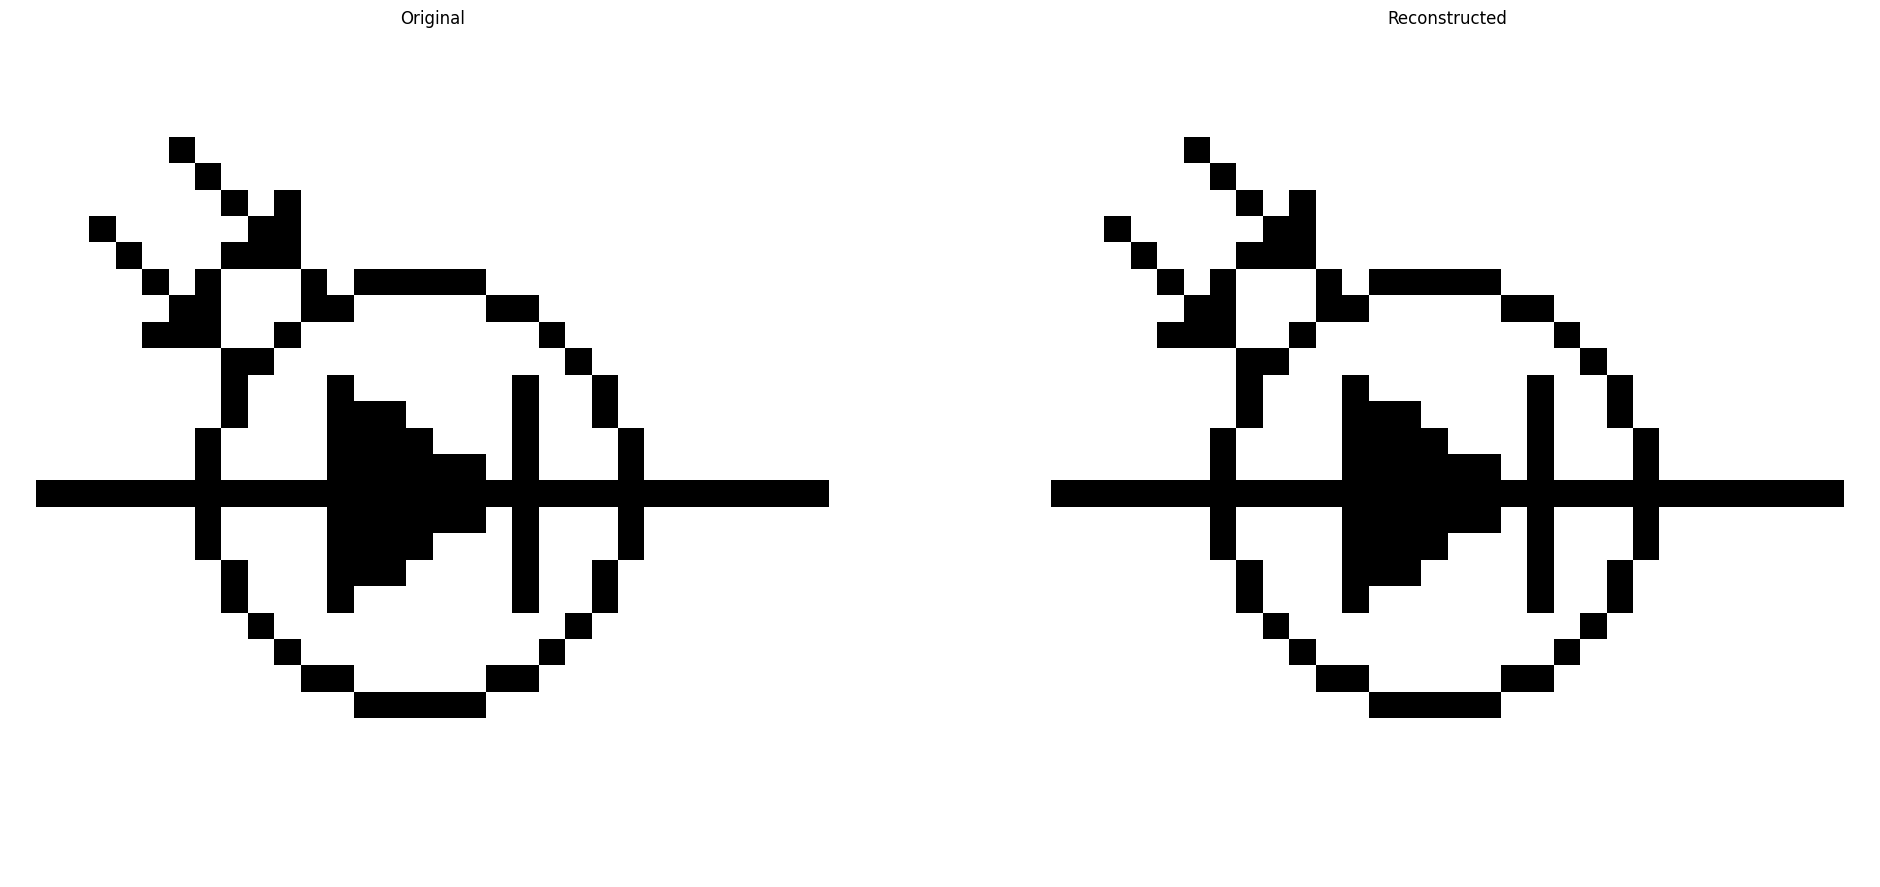

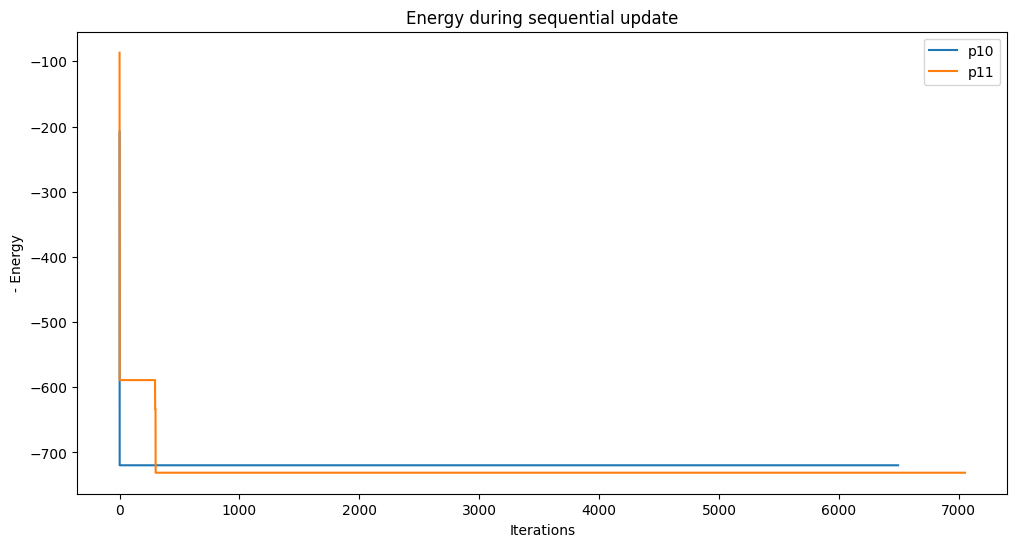

In [11]:
p10 = data[9].clone()
p11 = data[10].clone()
predicted_p10, energy_p10 = hopfield_seq.predict_asynchronous_nrj(p10, p1)
predicted_p11, energy_p11 = hopfield_seq.predict_asynchronous_nrj(p11, p3)

plt.figure(figsize=(12, 6))
plt.plot(energy_p10, label="p10")
plt.plot(energy_p11, label="p11")
plt.xlabel("Iterations")
plt.ylabel("- Energy")
plt.legend()
plt.title("Energy during sequential update")
plt.savefig("images/energy.png")
plt.show()

tensor([[ 0.9323, -0.3972, -1.3437,  ...,  0.1386, -0.7393, -0.1949],
        [ 0.5878,  2.3209, -0.8456,  ..., -0.7759,  0.5981, -0.6396],
        [ 0.6133, -0.8614,  2.0389,  ...,  1.0125, -0.8933,  0.7416],
        ...,
        [-0.1151,  2.4088, -0.4749,  ...,  0.6157,  0.8008, -1.1121],
        [-0.6296, -0.7817, -0.6061,  ..., -1.8573, -0.3595, -0.0583],
        [-0.2932,  0.9796, -1.0783,  ...,  0.2449, -0.9171, -0.8922]])


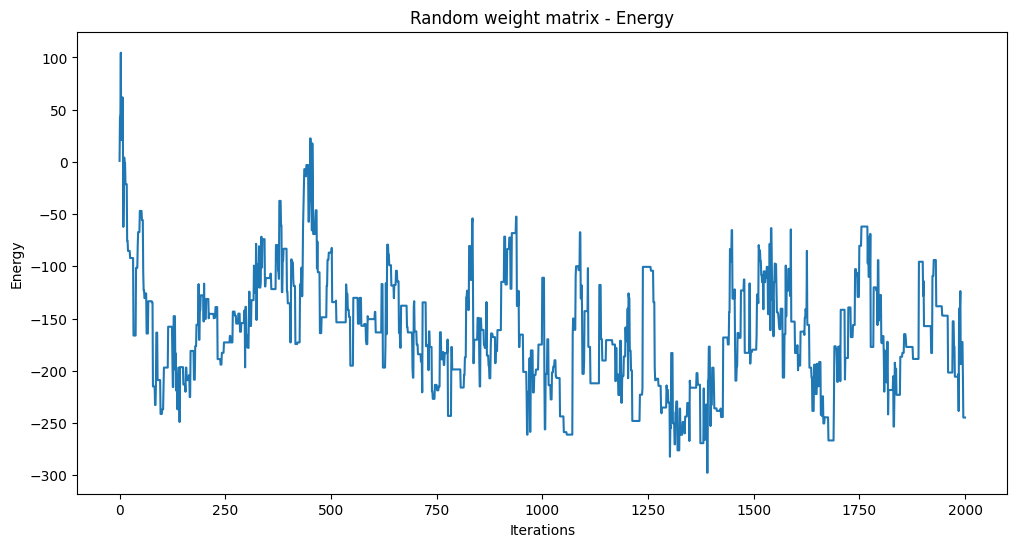

In [12]:
# Generating  a weight matrix by setting the weights to normally distributed random number
dim = 100
hopfield_rand = HopfieldNetwork(dim)
hopfield_rand.set_weights(torch.randn(dim, dim))
print(hopfield_rand.get_weights())


#  try iterating an arbitrary starting state
x = torch.randint(0, 2, (dim,)).float() * 2 - 1
x = x.float()
max_iter = 2000
output, energy_rand = hopfield_rand.predict_asynchronous_nrj(x, max_iter = max_iter)


plt.figure(figsize=(12, 6))
plt.plot(energy_rand)
plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Random weight matrix - Energy")
plt.savefig("images/energy-random.png")
plt.show()

tensor([[-2.1590, -0.0070, -0.7693,  ...,  0.8947, -0.5216,  0.1326],
        [-0.0070,  0.2364,  0.6623,  ..., -0.0601, -0.3914,  0.4977],
        [-0.7693,  0.6623, -1.8647,  ..., -0.1427, -0.1657, -0.0486],
        ...,
        [ 0.8947, -0.0601, -0.1427,  ..., -0.2089, -0.1308,  0.3404],
        [-0.5216, -0.3914, -0.1657,  ..., -0.1308,  0.6640,  1.3272],
        [ 0.1326,  0.4977, -0.0486,  ...,  0.3404,  1.3272, -0.6257]])


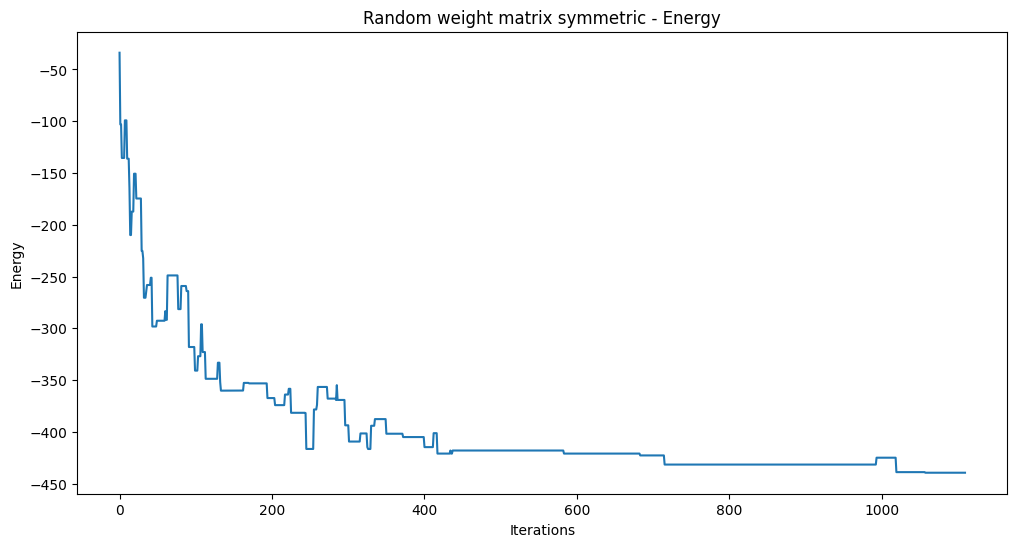

In [13]:
# Generating  a weight matrix by setting the weights to normally distributed random number
dim = 100
hopfield_sym = HopfieldNetwork(dim)
W = torch.randn(dim, dim)
W = (W + W.T) / 2
hopfield_sym.set_weights(W)
print(hopfield_sym.get_weights())


#  try iterating an arbitrary starting state
x = torch.randint(0, 2, (dim,)).float() * 2 - 1
x = x.float()
max_iter = 2000
output, energy_sym = hopfield_sym.predict_asynchronous_nrj(x, max_iter=max_iter)


plt.figure(figsize=(12, 6))
plt.plot(energy_sym)
plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Random weight matrix symmetric - Energy")
plt.savefig("images/energy-random-symmetric.png")
plt.show()

## 3.4 - Distortion Resistance


All patterns are stable


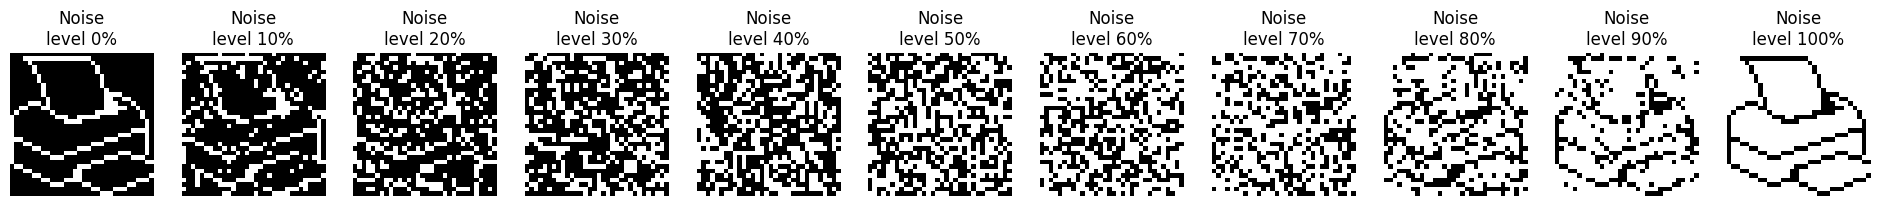

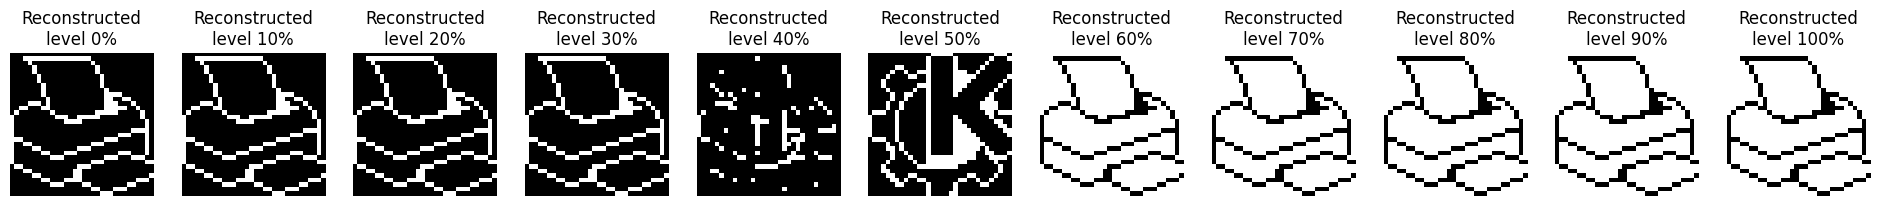

In [14]:
p1 = data[0].clone()
p2 = data[1].clone()
p3 = data[2].clone()

dim = 1024
hopfield = HopfieldNetwork(dim)
hopfield.train(data[:3])
# Check if all patterns are stable
for x in data[:3]:
    assert torch.all(hopfield.update_rule(x) == x)
print("All patterns are stable")

# Add noise to p1 from 0 to 100%
p1_noisy = []
for i in range(11):
    p1_noisy.append(p1.clone())
    p1_noisy[i][torch.randperm(dim)[:int(i/10*dim)]] *= -1

plot_images(p1_noisy, (32, 32), [
            f"Noise\nlevel {i*10}%" for i in range(11)], "images/p1-noisy.png")

# Predict with noisy p1
predicted_p1_noisy = [hopfield.predict_sync(x) for x in p1_noisy]

plot_images(predicted_p1_noisy, (32, 32), [
            f"Reconstructed\nlevel {i*10}%" for i in range(11)], "images/p1-reconstructed-noisy.png")

> The 10th pattern is no more converging to the correct pattern.


## 3.5 - Capacity


> Learning from the pictures

Reconstructed patterns with 3 patterns stored


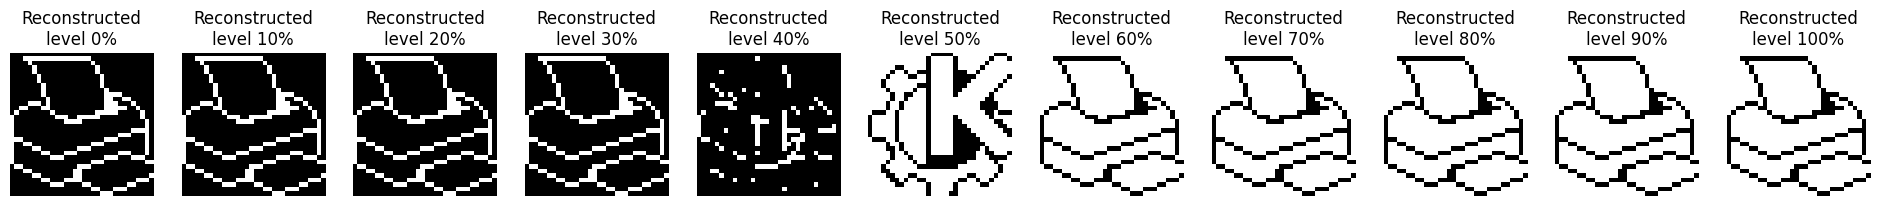

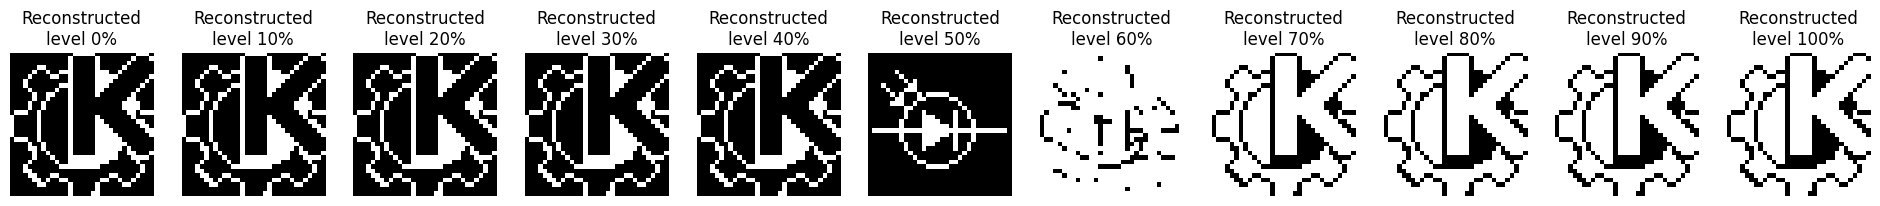

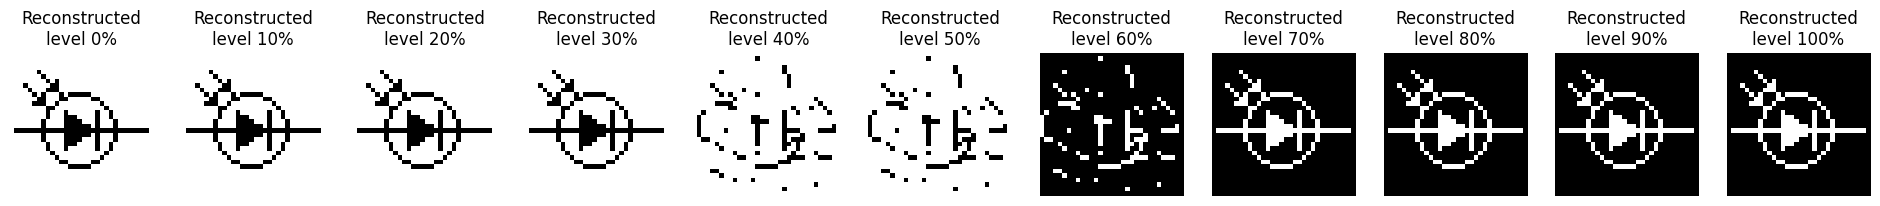

Reconstructed patterns with 4 patterns stored


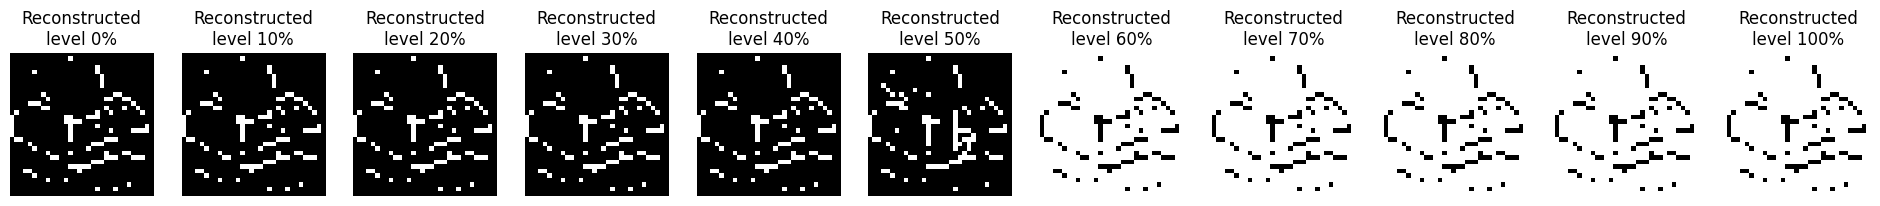

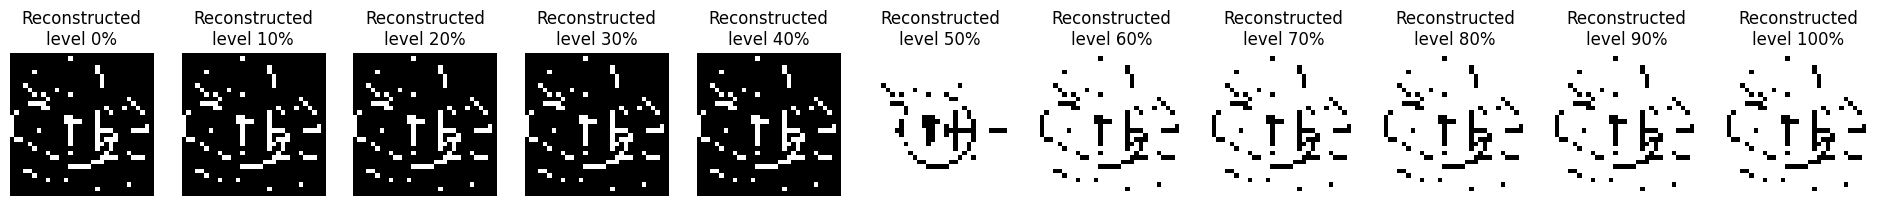

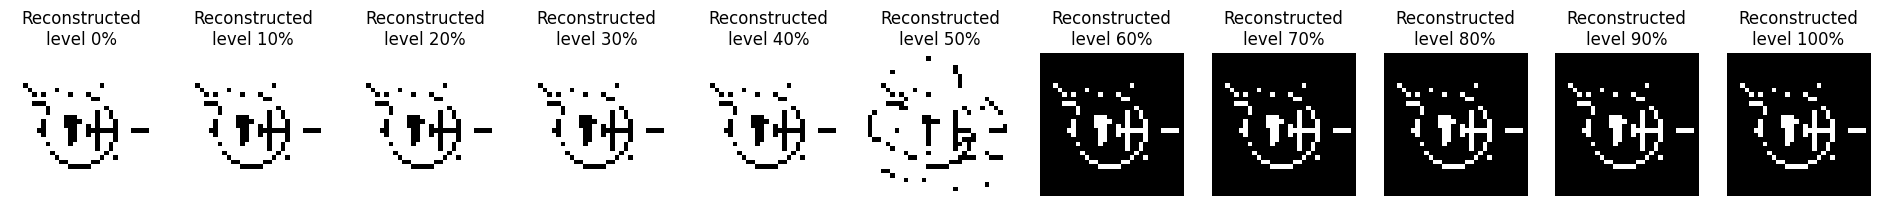

Reconstructed patterns with 5 patterns stored


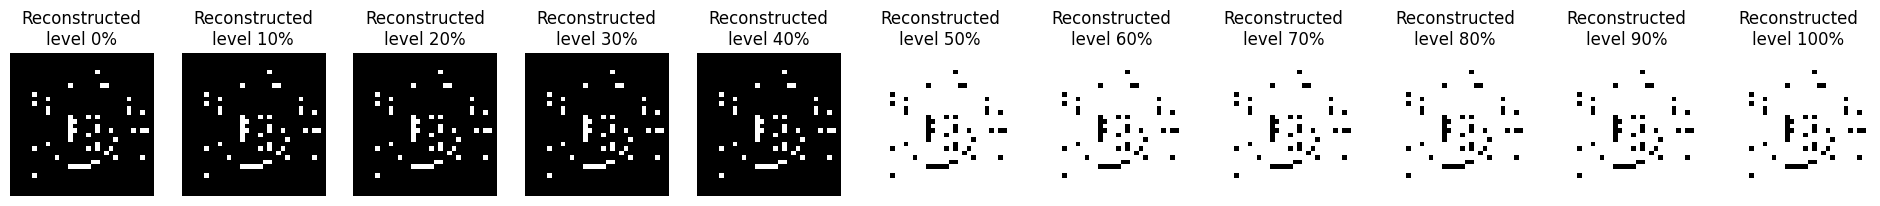

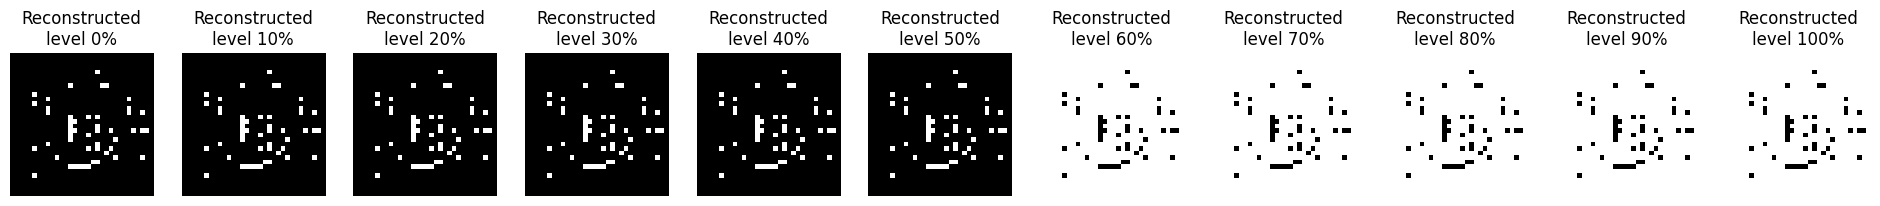

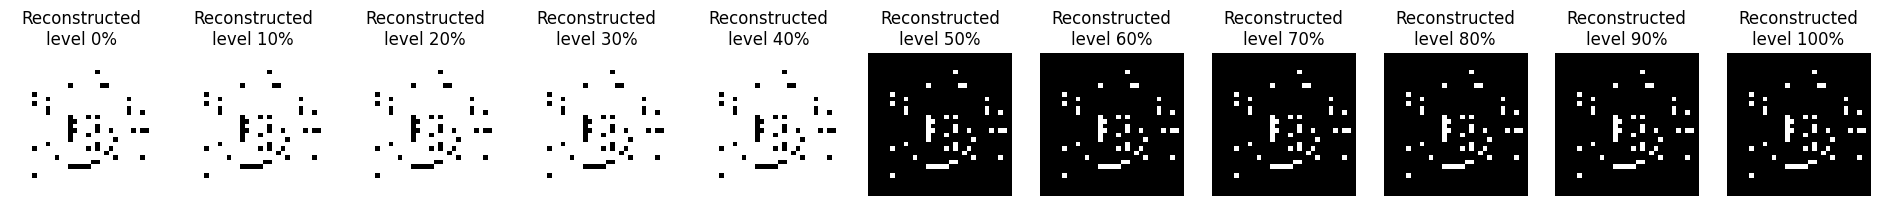

Reconstructed patterns with 6 patterns stored


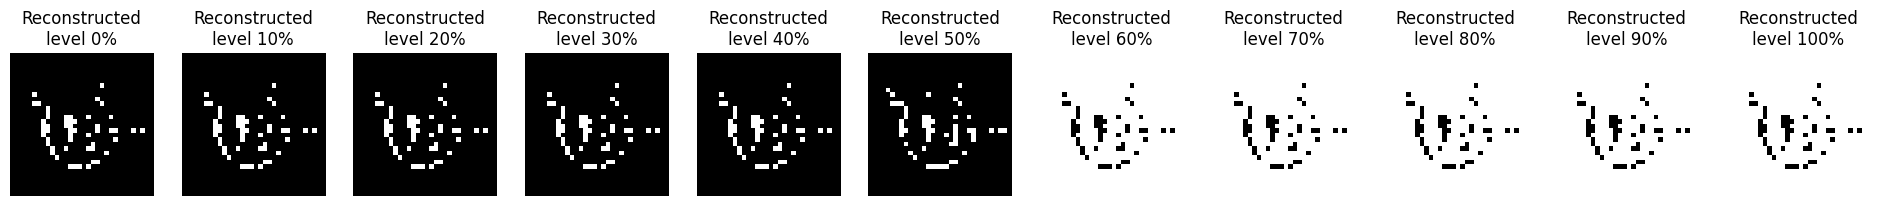

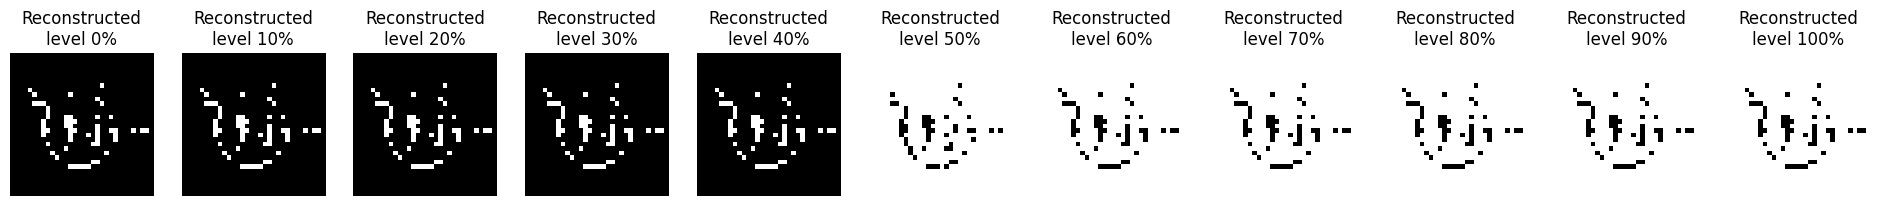

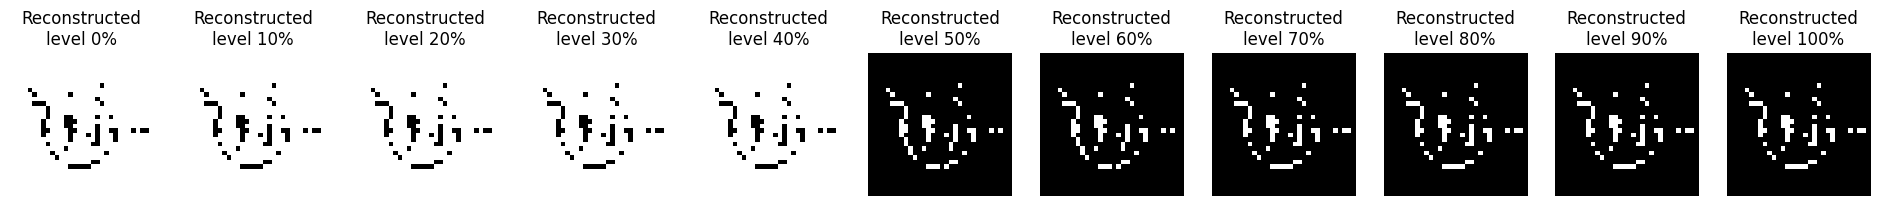

Reconstructed patterns with 7 patterns stored


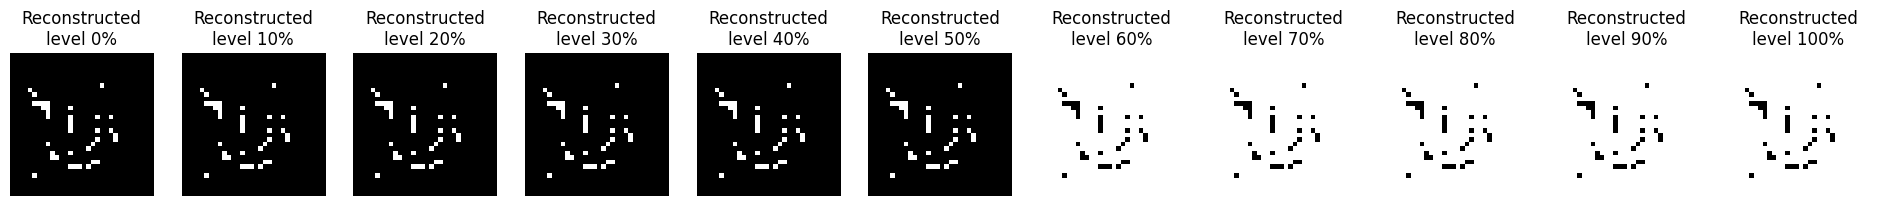

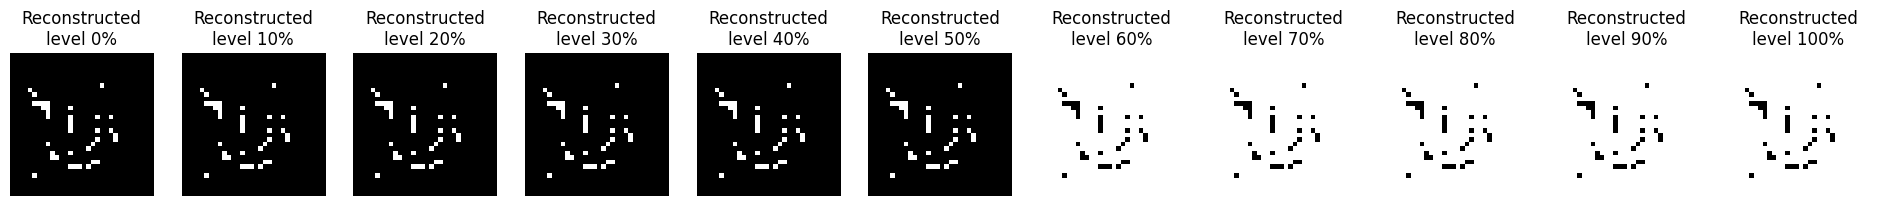

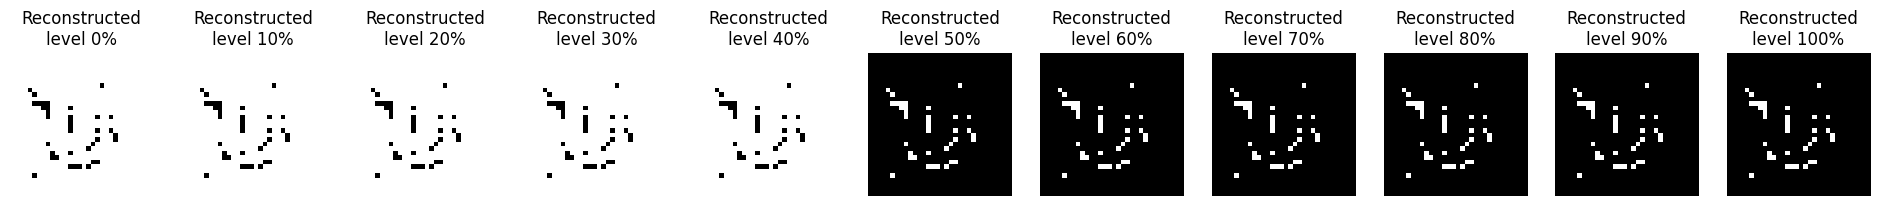

In [15]:
for i in range(3, 8):
    hopfield = HopfieldNetwork(dim)
    hopfield.train(data[:i])
    p1_noisy, p2_noisy, p3_noisy = [], [], []
    for j in range(11):
        p1_noisy.append(p1.clone())
        p2_noisy.append(p2.clone())
        p3_noisy.append(p3.clone())
        p1_noisy[j][torch.randperm(dim)[:int(j/10*dim)]] *= -1
        p2_noisy[j][torch.randperm(dim)[:int(j/10*dim)]] *= -1
        p3_noisy[j][torch.randperm(dim)[:int(j/10*dim)]] *= -1
    predicted_p1_noisy = [hopfield.predict_sync(x) for x in p1_noisy]
    predicted_p2_noisy = [hopfield.predict_sync(x) for x in p2_noisy]
    predicted_p3_noisy = [hopfield.predict_sync(x) for x in p3_noisy]
    print(f"Reconstructed patterns with {i} patterns stored")
    plot_images(predicted_p1_noisy, (32, 32), [
                f"Reconstructed\nlevel {j*10}%" for j in range(11)], f"images/p1-reconstructed-noisy-{i}-capacity.png")
    plot_images(predicted_p2_noisy, (32, 32), [
                f"Reconstructed\nlevel {j*10}%" for j in range(11)], f"images/p2-reconstructed-noisy-{i}-capacity.png")
    plot_images(predicted_p3_noisy, (32, 32), [
                f"Reconstructed\nlevel {j*10}%" for j in range(11)], f"images/p3-reconstructed-noisy-{i}-capacity.png")


> Learning from random pictures

In [16]:
random_patterns = [torch.randint(0, 2, (dim,)).float() * 2 - 1 for _ in range(200)]

all_match_data = []
all_match_data_bis = []

for i in range(10, 200, 20):
    hopfield = HopfieldNetwork(dim)
    hopfield.train(random_patterns[:i])
    p1_noisy = []
    p_noisy = []
    for j in range(11):
        p1_noisy.append(random_patterns[0].clone())
        p1_noisy[j][torch.randperm(dim)[:int(j/10*dim)]] *= -1
        p_noisy.append(random_patterns[i-1].clone())
        p_noisy[j][torch.randperm(dim)[:int(j/10*dim)]] *= -1
    predicted_p1_noisy = [hopfield.predict_sync(x) for x in p1_noisy]
    predicted_p_noisy = [hopfield.predict_sync(x) for x in p_noisy]

    match_data = {
        f'{i} Learned patterns': [torch.equal(predicted_p1_noisy[j], random_patterns[0]) or torch.equal(predicted_p1_noisy[j], -random_patterns[0]) for j in range(11)]
    }
    match_data_bis = {
        f'{i} Learned patterns': [torch.equal(predicted_p_noisy[j], random_patterns[i-1]) or torch.equal(predicted_p_noisy[j], -random_patterns[i-1]) for j in range(11)]
    }
    
    all_match_data.append(match_data)
    all_match_data_bis.append(match_data_bis)

all_match_df = pd.concat([pd.DataFrame(data) for data in all_match_data], axis=1)
all_match_bis_df = pd.concat([pd.DataFrame(data) for data in all_match_data_bis], axis=1)

display("Match table with different numbers of patterns stored:")
display(all_match_df)
display(all_match_bis_df)

'Match table with different numbers of patterns stored:'

,10 Learned patterns,30 Learned patterns,50 Learned patterns,70 Learned patterns,90 Learned patterns,110 Learned patterns,130 Learned patterns,150 Learned patterns,170 Learned patterns,190 Learned patterns
0,True,True,True,True,True,True,True,True,False,False
1,True,True,True,True,True,True,False,False,False,False
2,True,True,True,True,False,True,False,False,False,False
3,True,True,True,True,False,False,False,False,False,False
4,True,True,True,True,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False
6,True,True,True,True,False,False,False,False,False,False
7,True,True,True,True,False,False,False,False,False,False
8,True,True,True,True,True,False,False,False,False,False
9,True,True,True,True,True,True,False,True,False,False


,10 Learned patterns,30 Learned patterns,50 Learned patterns,70 Learned patterns,90 Learned patterns,110 Learned patterns,130 Learned patterns,150 Learned patterns,170 Learned patterns,190 Learned patterns
0,True,True,True,True,True,False,True,False,False,False
1,True,True,True,True,True,False,False,False,False,False
2,True,True,True,True,True,False,False,False,False,False
3,True,True,True,True,True,False,False,False,False,False
4,True,True,True,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False
6,True,True,True,False,False,False,False,False,False,False
7,True,True,True,True,True,False,False,False,False,False
8,True,True,True,True,True,False,False,False,False,False
9,True,True,True,True,True,False,False,False,False,False


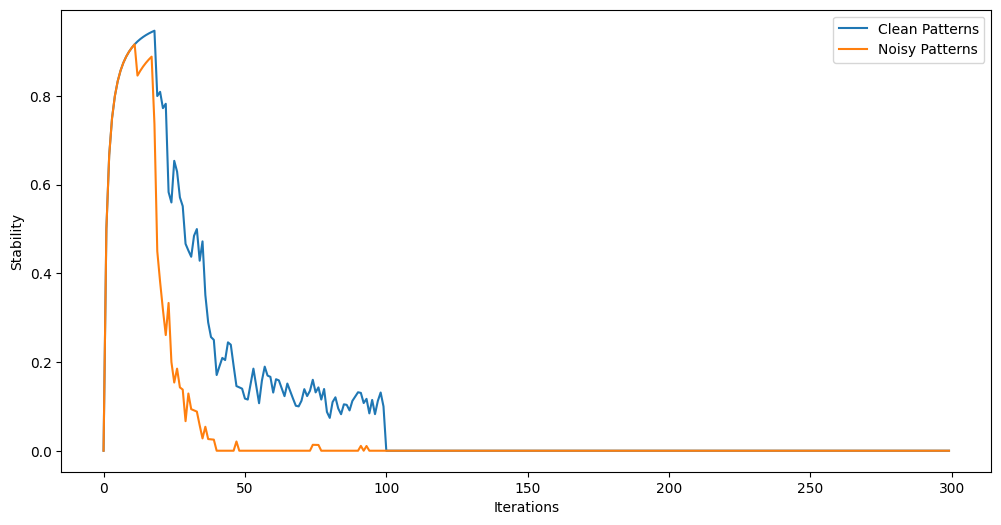

In [17]:
random_patterns = torch.randint(0, 2, (300, 100)).float() * 2 - 1

stability, stability_noisy = np.zeros((300,)), np.zeros((300,))
hopfield_stab = HopfieldNetwork(100)
random_patterns_noisy = random_patterns.clone()

for i in range(0, 100):
    random_patterns_noisy[i,torch.randperm(100)[:int(10)]] *= -1
    hopfield_stab.train(random_patterns[:i])
    for j in range(i + 1):
        # Checking stability with clean patterns
        if torch.all(hopfield_stab.update_rule(random_patterns[j]) == random_patterns[j]):
            stability[i] += 1 / (i+1)
        # Checking stability with noisy patterns
        if torch.all(hopfield_stab.predict_sync(random_patterns_noisy[j]) == random_patterns[j]):
            stability_noisy[i] += 1 / (i+1)

plt.figure(figsize=(12, 6))
plt.plot(stability, label='Clean Patterns')
plt.plot(stability_noisy, label='Noisy Patterns')
plt.xlabel("Iterations")
plt.ylabel("Stability")
plt.legend()
plt.savefig("images/stability.png")
plt.show()

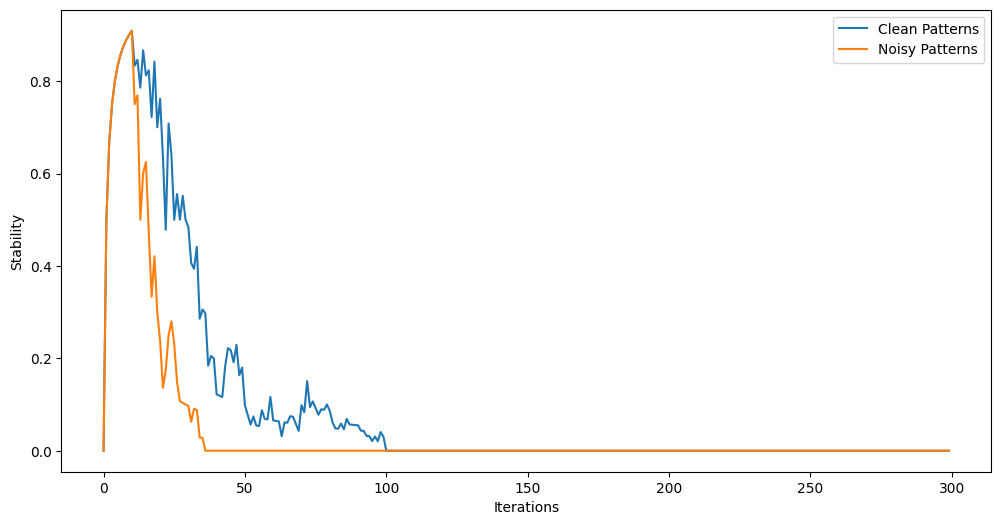

In [18]:
random_patterns = torch.randint(0, 2, (300, 100)).float() * 2 - 1

stability, stability_noisy = np.zeros((300,)), np.zeros((300,))
hopfield_stab = HopfieldNetwork(100)
random_patterns_noisy = random_patterns.clone()

for i in range(0, 100):
    random_patterns_noisy[i,torch.randperm(100)[:int(10)]] *= -1
    hopfield_stab.train(random_patterns[:i])
    for j in range(i + 1):
        # Checking stability with clean patterns
        if torch.all(hopfield_stab.update_rule(random_patterns[j]) == random_patterns[j]):
            stability[i] += 1 / (i+1)
        # Checking stability with noisy patterns
        if torch.all(hopfield_stab.predict_sync(random_patterns_noisy[j]) == random_patterns[j]):
            stability_noisy[i] += 1 / (i+1)

plt.figure(figsize=(12, 6))
plt.plot(stability, label='Clean Patterns')
plt.plot(stability_noisy, label='Noisy Patterns')
plt.xlabel("Iterations")
plt.ylabel("Stability")
plt.legend()
plt.savefig("images/stability.png")
plt.show()

## 3.6 Sparse patterns

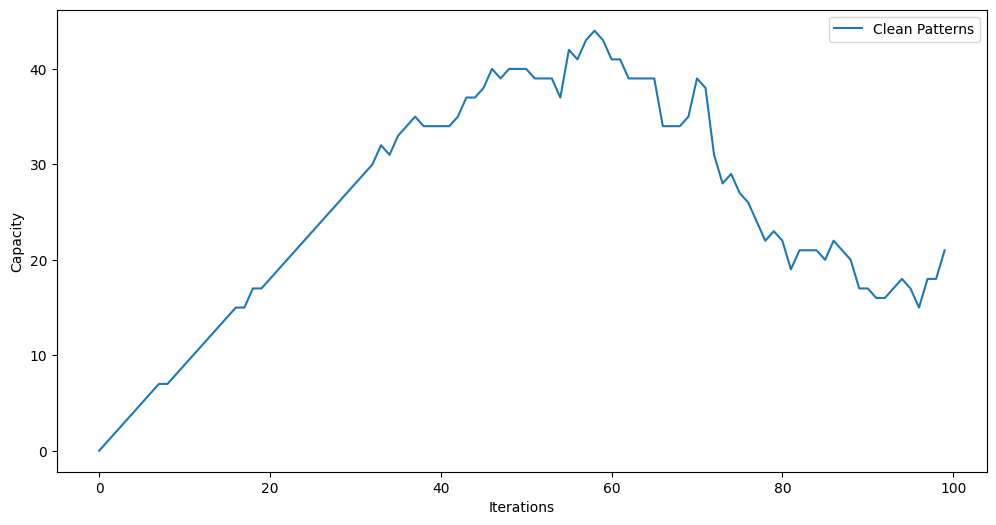

In [19]:
def generate_binary_matrix(rows, cols, rho):
    num_active_elements = int(rho * rows * cols)
    binary_matrix = np.zeros((rows, cols), dtype=int)
    active_indices = np.random.choice(rows * cols, num_active_elements, replace=False)
    binary_matrix.flat[active_indices] = 1
    return binary_matrix

random_patterns = generate_binary_matrix(100, 100, 0.1)
hopfield = HopfieldNetwork(100, 0.05)
capacity = np.zeros((100,))
rho = hopfield.avg_activity(random_patterns)
random_patterns_tensor = torch.tensor(random_patterns)

for i in range(0, 100):
    hopfield.train_bias(random_patterns_tensor[:i], rho)
    for j in range(i + 1):
        random_pattern_j_tensor = torch.tensor(random_patterns[j])
        if torch.all(hopfield.update_rule_bias(random_pattern_j_tensor) == random_pattern_j_tensor):
            capacity[i] += 1 #/ (i + 1)

plt.figure(figsize=(12, 6))
plt.plot(capacity, label='Clean Patterns')
plt.xlabel("Iterations")
plt.ylabel("Capacity")
plt.legend()
plt.savefig("images/capacity.png")
plt.show()